<a href="https://colab.research.google.com/github/Jess-Lau/Real-Life-B-W-Video-Colorization-Project/blob/main/ImageColorizerV3GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os
import sys
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from datetime import datetime
from keras.layers import (
    Activation, AveragePooling2D, BatchNormalization, Conv2D, Conv2DTranspose,
    Dense, Dropout, Flatten, Input, LeakyReLU, ReLU, UpSampling2D)
from keras.datasets import cifar10
from keras.models import Sequential, Model
from time import time
from skimage.color import rgb2lab, lab2rgb


IMAGE_SIZE = 32
EPOCHS = 100
BATCH_SIZE = 128
SHUFFLE_BUFFER_SIZE = 100

WORKDIR = "/content"

In [13]:
def generate_dataset(images, debug=False):
    X = []
    Y = []

    for i in images:
        lab_image_array = rgb2lab(i / 255)
        x = lab_image_array[:, :, 0]
        y = lab_image_array[:, :, 1:]
        y /= 128  # normalize

        if debug:
            fig = plt.figure()
            fig.add_subplot(1, 2, 1)
            plt.imshow(i / 255)

            fig.add_subplot(1, 2, 2)
            plt.imshow(lab2rgb(np.dstack((x, y * 128))))
            plt.show()

        X.append(x.reshape(IMAGE_SIZE, IMAGE_SIZE, 1))
        Y.append(y)

    X = np.array(X, dtype=np.float32)
    Y = np.array(Y, dtype=np.float32)

    return X, Y


def load_data(force=False):
    is_saved_arrays_exist = os.path.isfile(os.path.join(WORKDIR, 'X_train.npy'))

    if not is_saved_arrays_exist or force:
        (train_images, _), (test_images, _) = cifar10.load_data()
        X_train, Y_train = generate_dataset(train_images)
        X_test, Y_test = generate_dataset(test_images)
        print('Saving processed data to Drive')
        np.save(os.path.join(WORKDIR, 'X_train.npy'), X_train)
        np.save(os.path.join(WORKDIR, 'Y_train.npy'), Y_train)
        np.save(os.path.join(WORKDIR, 'X_test.npy'), X_test)
        np.save(os.path.join(WORKDIR, 'Y_test.npy'), Y_test)
    else:
        print('Loading processed data from Drive')
        X_train = np.load(os.path.join(WORKDIR, 'X_train.npy'))
        Y_train = np.load(os.path.join(WORKDIR, 'Y_train.npy'))
        X_test = np.load(os.path.join(WORKDIR, 'X_test.npy'))
        Y_test = np.load(os.path.join(WORKDIR, 'Y_test.npy'))


    return X_train, Y_train, X_test, Y_test


X_train, Y_train, X_test, Y_test = load_data()

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, Y_test))

train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

Loading processed data from Drive


In [4]:
def make_generator_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(IMAGE_SIZE, IMAGE_SIZE, 1)))
    model.add(Conv2D(64, (3, 3), padding='same', strides=2, activation='relu'))
    model.add(BatchNormalization())
    # model = MaxPooling2D(pool_size=(2, 2))(model)

    model.add(Conv2D(128, (3, 3), padding='same', activation='relu', strides=2))
    model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    # model = MaxPooling2D(pool_size=(2, 2))(model)

    model.add(Conv2D(256, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())

    model.add(UpSampling2D(size=(2,2)))
    model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())

    model.add(UpSampling2D(size=(2,2)))
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())

    model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(2, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('tanh'))
    # self.model = BatchNormalization()(self.model)
    # self.model = merge(inputs=[self.g_input, self.model], mode='concat')
    # self.model = Activation('linear')(self.model)
    return model

In [5]:
def downsample(filters, kernel_size, apply_batchnorm=True):
    initializer = tf.random_uniform_initializer(0, 0.02)
    model = Sequential()
    model.add(Conv2D(filters, kernel_size, strides=2, padding='same',
                     kernel_initializer=initializer, use_bias=False))

    if apply_batchnorm:
        model.add(BatchNormalization())

    model.add(LeakyReLU())
    return model


def upsample(filters, kernel_size, apply_dropout=False):
    initializer = tf.random_uniform_initializer(0, 0.02)
    model = Sequential()
    model.add(Conv2DTranspose(filters, kernel_size, strides=2, padding='same',
                              kernel_initializer=initializer, use_bias=False))
    model.add(BatchNormalization())

    if apply_dropout:
        model.add(Dropout(0.5))

    model.add(ReLU())
    return model


def make_autoencoder_generator_model():
    inputs = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 1))

    # Downsampling layers
    # 1: (BATCH_SIZE, 16, 16, 32)
    # 2: (BATCH_SIZE, 8, 8, 64)
    # 3: (BATCH_SIZE, 4, 4, 128)
    # 4: (BATCH_SIZE, 2, 2, 256)
    # 5: (BATCH_SIZE, 1, 1, 256)

    downstack = [
        downsample(32, 4, apply_batchnorm=False),
        downsample(64, 4),
        downsample(128, 4),
        downsample(256, 4),
        downsample(256, 4)
    ]

    # Upsampling layers
    # 1: (BATCH_SIZE, 1, 1, 256)
    # 2: (BATCH_SIZE, 1, 1, 128)
    # 3: (BATCH_SIZE, 1, 1, 64)
    # 4: (BATCH_SIZE, 1, 1, 32)

    upstack = [
        upsample(256, 4, apply_dropout=True),
        upsample(128, 4),
        upsample(64, 4),
        upsample(32, 4),
    ]

    initializer = tf.random_uniform_initializer(0, 0.02)
    output_layer = Conv2DTranspose(2, 3, strides=2, padding='same',
                                   kernel_initializer=initializer,
                                   activation='tanh')

    x = inputs

    # Downsampling layers
    skips = []
    for dm in downstack:
        x = dm(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling layers
    for um, skip in zip(upstack, skips):
        x = um(x)
        x = tf.keras.layers.Concatenate()([x, skip])

    x = output_layer(x)

    return Model(inputs=inputs, outputs=x)

In [6]:
def make_discriminator_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))
    model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
    model.add(AveragePooling2D(pool_size=(2, 2)))
    model.add(Dropout(.25))

    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(AveragePooling2D(pool_size=(2, 2)))
    model.add(Dropout(.25))

    model.add(Flatten())
    model.add(Dense(512))
    model.add(LeakyReLU(.2))
    model.add(BatchNormalization())
    model.add(Dropout(.5))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))

    return model

In [7]:
LAMBDA = 100
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)


def discriminator_loss(disc_real_output, disc_generated_output):
    real_loss = cross_entropy(tf.ones_like(disc_real_output), disc_real_output)
    generated_loss = cross_entropy(tf.zeros_like(disc_generated_output), disc_generated_output)
    total_disc_loss = real_loss + generated_loss
    return total_disc_loss


def generator_loss(disc_generated_output, gen_output, target):
    gan_loss = cross_entropy(tf.ones_like(disc_generated_output), disc_generated_output)
    # mean absolute error
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))
    total_gen_loss = gan_loss + (LAMBDA * l1_loss)
    return total_gen_loss, gan_loss, l1_loss

In [8]:
generator = make_autoencoder_generator_model()
discriminator = make_discriminator_model()

generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

checkpoint_dir = os.path.join(WORKDIR, 'training-checkpoints')
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)
manager = tf.train.CheckpointManager(checkpoint, checkpoint_dir, max_to_keep=3)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [9]:
summary_log_file = os.path.join(
    WORKDIR, 'tf-summary', datetime.now().strftime("%Y%m%d-%H%M%S"))
summary_writer = tf.summary.create_file_writer(summary_log_file)

@tf.function
def train_step(input_image, target, epoch):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_output = generator(input_image, training=True)

        disc_real_output = discriminator(tf.keras.layers.concatenate([input_image, target]), training=True)
        disc_generated_output = discriminator(tf.keras.layers.concatenate([input_image, gen_output]), training=True)

        gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(
            disc_generated_output, gen_output, target)
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

    generator_gradients = gen_tape.gradient(gen_total_loss,
                                            generator.trainable_variables)
    discriminator_gradients = disc_tape.gradient(disc_loss,
                                                 discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))

    with summary_writer.as_default():
        tf.summary.scalar('gen_total_loss', gen_total_loss, step=epoch)
        tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=epoch)
        tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=epoch)
        tf.summary.scalar('disc_loss', disc_loss, step=epoch)

    return gen_total_loss, disc_loss

In [10]:
checkpoint.restore(manager.latest_checkpoint)
if manager.latest_checkpoint:
    print('Restored from {}'.format(manager.latest_checkpoint))
else:
    print('Initializing from scratch')

Restored from /content/training-checkpoints/ckpt-24


In [11]:
for e in range(EPOCHS):
    start_time = time()
    gen_loss_total = disc_loss_total = 0
    for input_image, target in train_dataset:
        gen_loss, disc_loss = train_step(input_image, target, e)
        gen_loss_total += gen_loss
        disc_loss_total += disc_loss

    time_taken = time() - start_time

    if (e + 1) % 10 == 0:
        checkpoint.save(file_prefix=checkpoint_prefix)

    print('Epoch {}: gen loss: {}, disc loss: {}, time: {:.2f}s'.format(
         e + 1, gen_loss_total / BATCH_SIZE, disc_loss_total / BATCH_SIZE, time_taken))

/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/nn.py:707: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


Epoch 1: gen loss: 11.746859550476074, disc loss: 4.2372026443481445, time: 39.92s
Epoch 2: gen loss: 11.750749588012695, disc loss: 4.237785339355469, time: 29.69s
Epoch 3: gen loss: 11.728065490722656, disc loss: 4.237805366516113, time: 28.98s
Epoch 4: gen loss: 11.728981018066406, disc loss: 4.236685276031494, time: 40.94s
Epoch 5: gen loss: 11.728724479675293, disc loss: 4.236841678619385, time: 29.54s
Epoch 6: gen loss: 11.720433235168457, disc loss: 4.2370452880859375, time: 28.96s
Epoch 7: gen loss: 11.717934608459473, disc loss: 4.237421989440918, time: 29.39s
Epoch 8: gen loss: 11.688495635986328, disc loss: 4.237485408782959, time: 29.21s
Epoch 9: gen loss: 11.69290542602539, disc loss: 4.237277984619141, time: 29.03s
Epoch 10: gen loss: 11.678523063659668, disc loss: 4.236868381500244, time: 40.94s
Epoch 11: gen loss: 11.655963897705078, disc loss: 4.237635612487793, time: 29.72s
Epoch 12: gen loss: 11.665367126464844, disc loss: 4.235860347747803, time: 29.26s
Epoch 13: ge

0


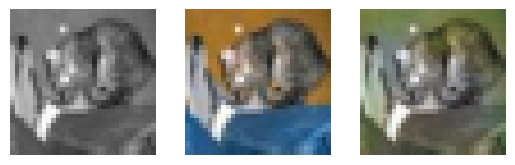

1 / 2501


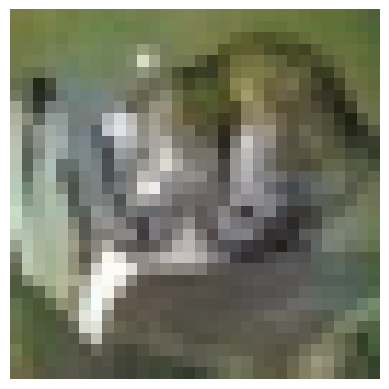

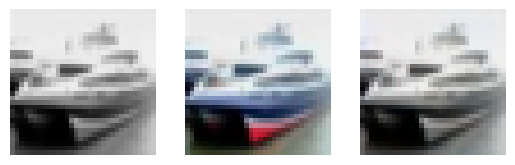

2 / 2502


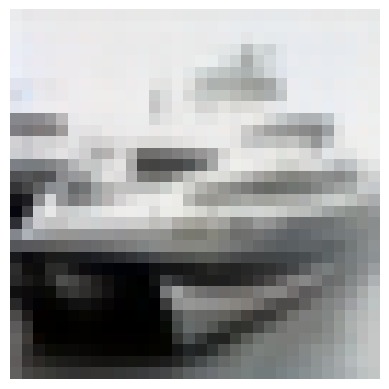

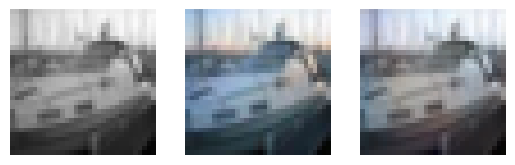

3 / 2503


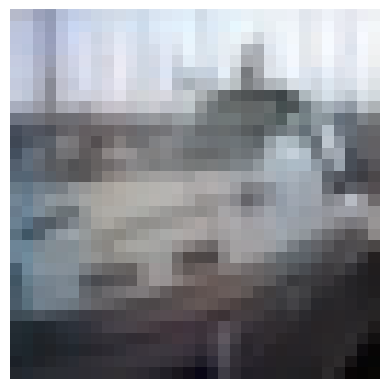

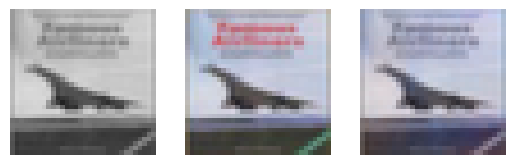

4 / 2504


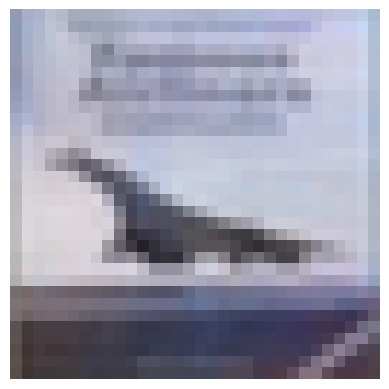

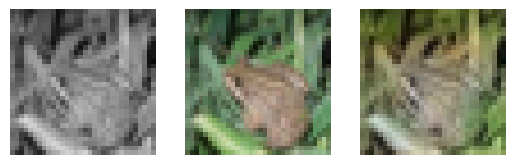

5 / 2505


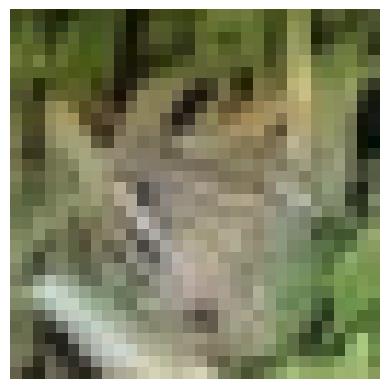

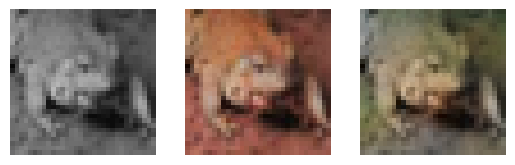

6 / 2506


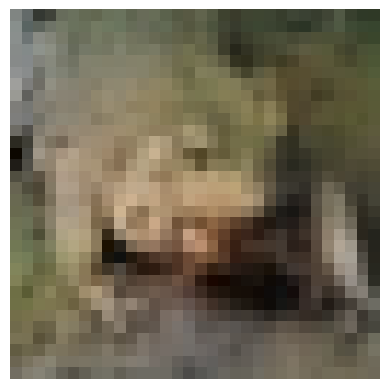

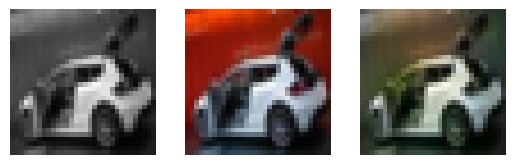

7 / 2507


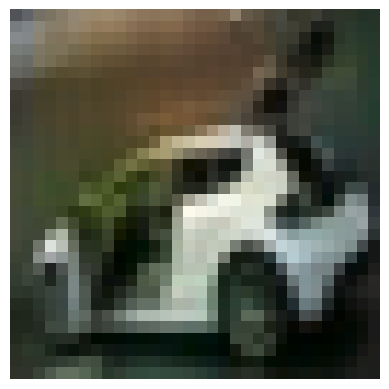

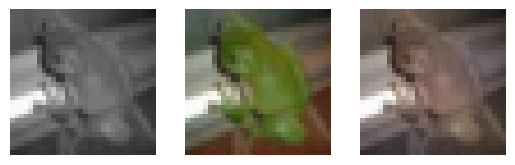

8 / 2508


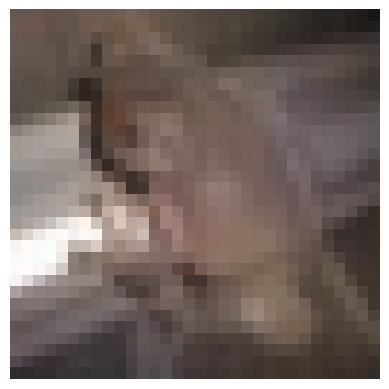

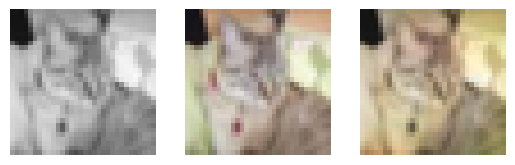

9 / 2509


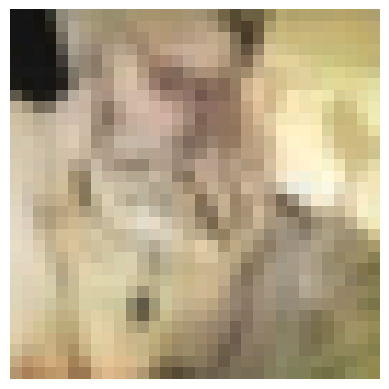

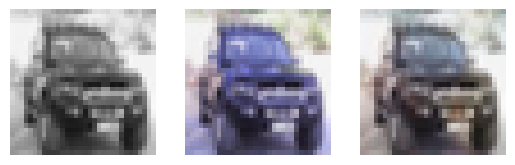

10 / 25010


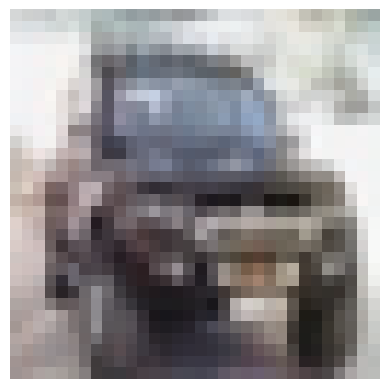

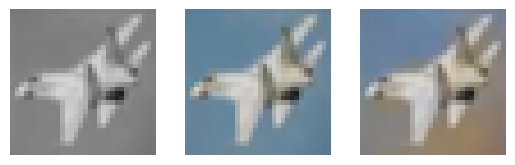

11 / 25011


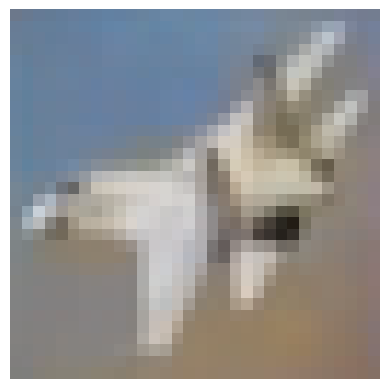

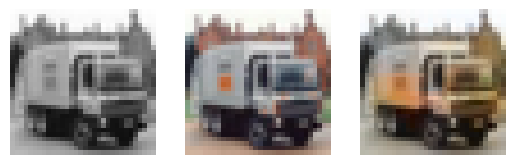

12 / 25012


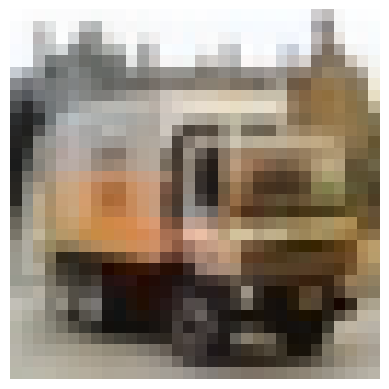

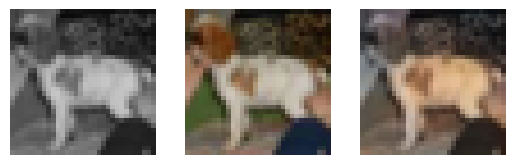

13 / 25013


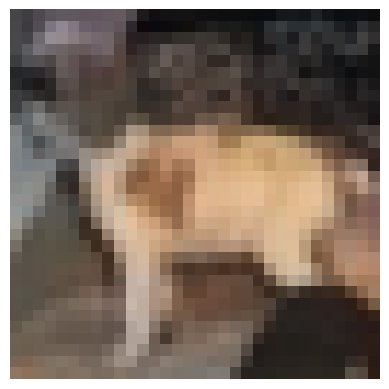

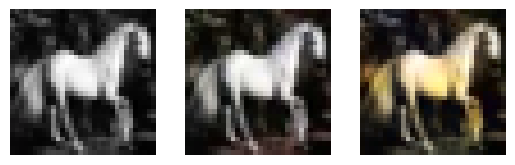

14 / 25014


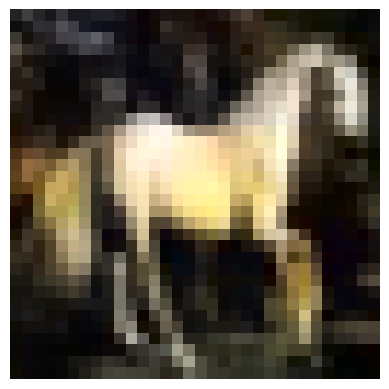

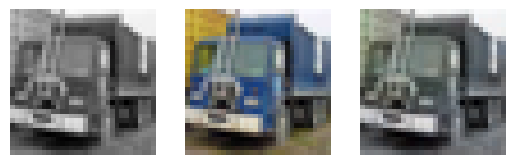

15 / 25015


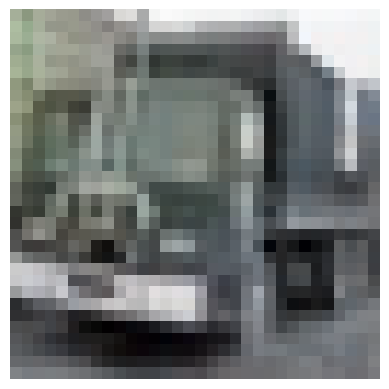

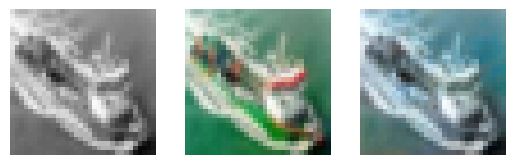

16 / 25016


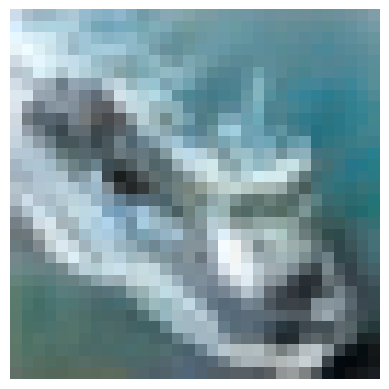

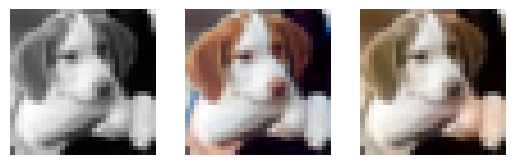

17 / 25017


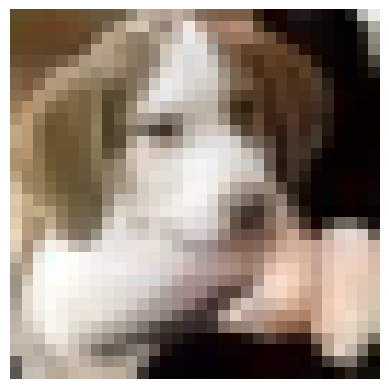

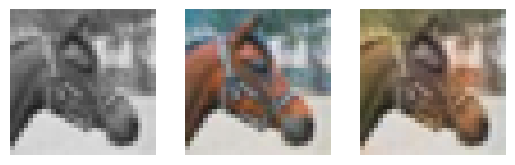

18 / 25018


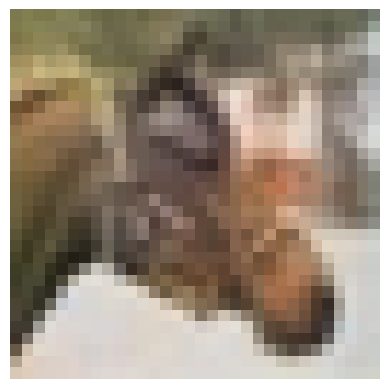

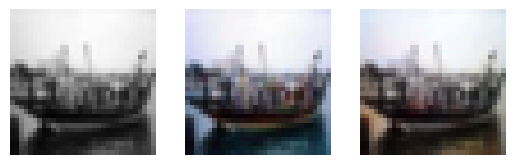

19 / 25019


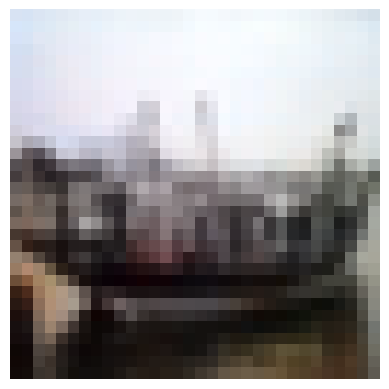

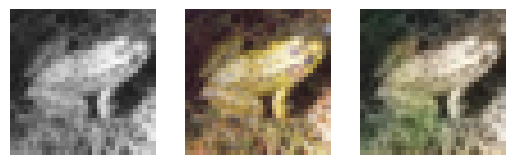

20 / 25020


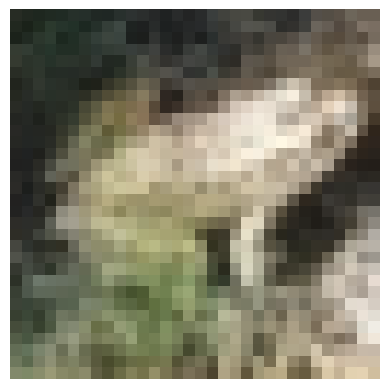

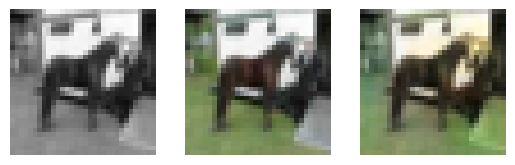

21 / 25021


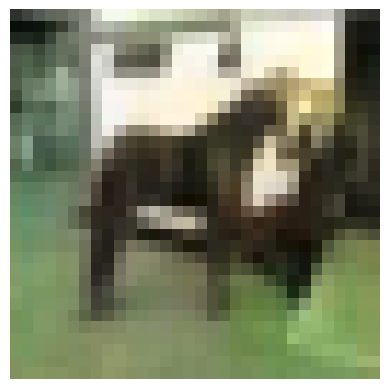

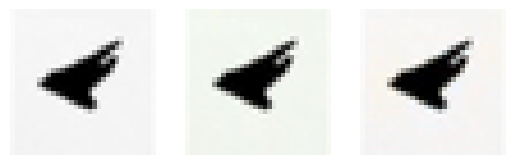

22 / 25022


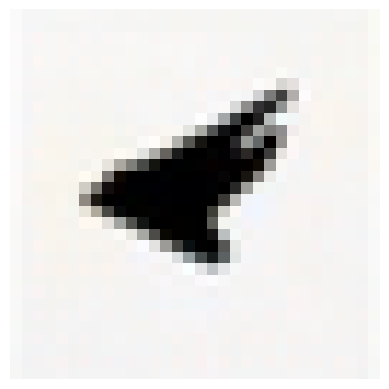

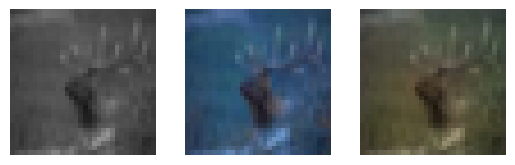

23 / 25023


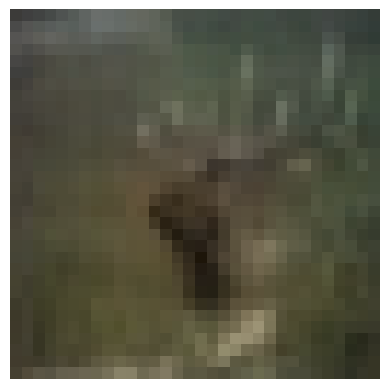

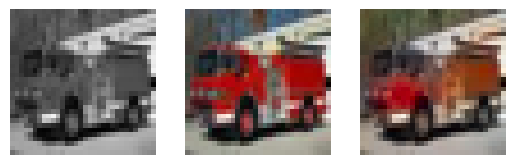

24 / 25024


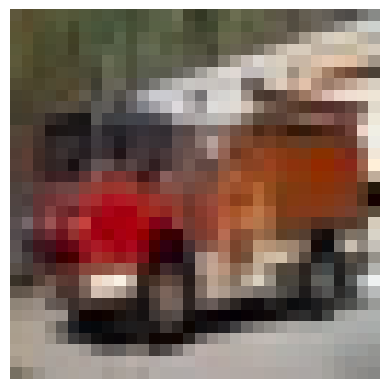

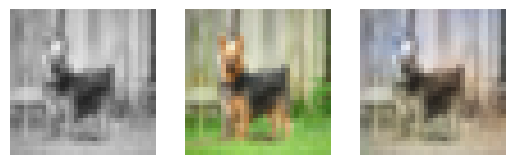

25 / 25025


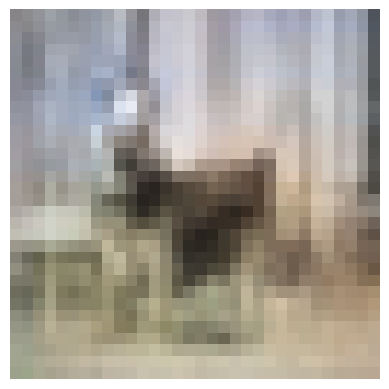

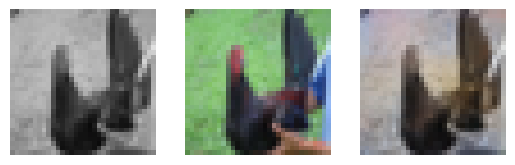

26 / 25026


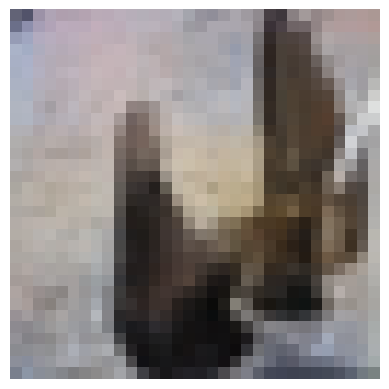

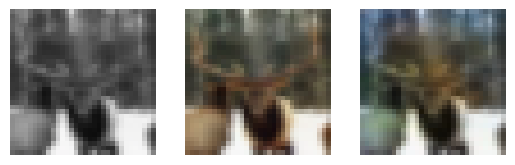

27 / 25027


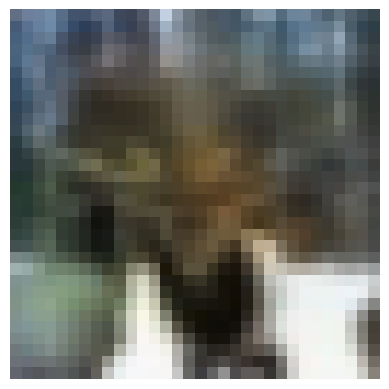

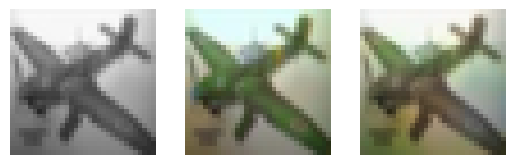

28 / 25028


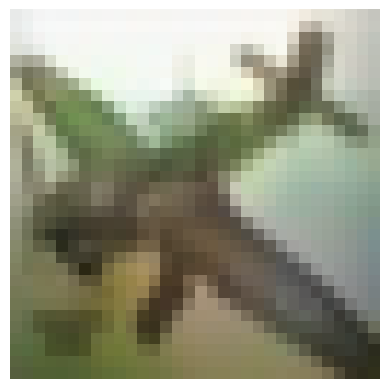

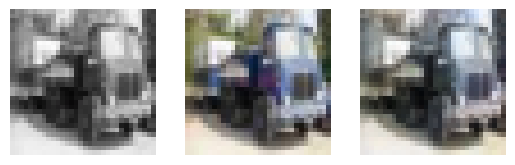

29 / 25029


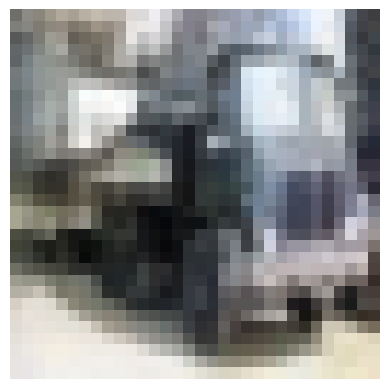

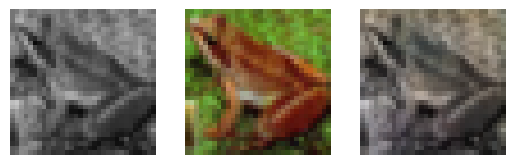

30 / 25030


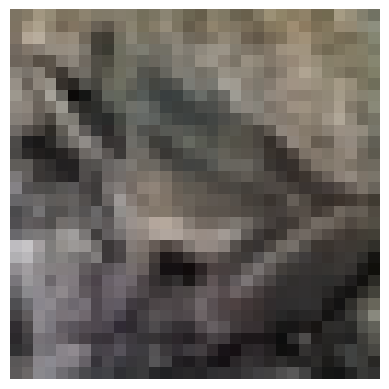

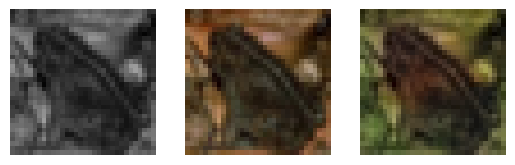

31 / 25031


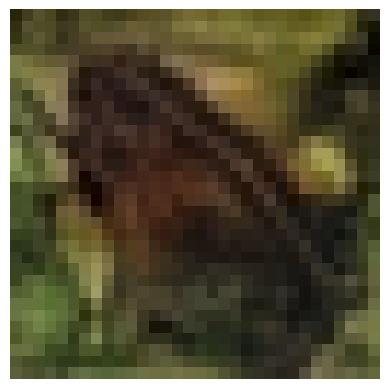

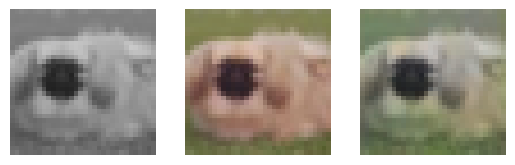

32 / 25032


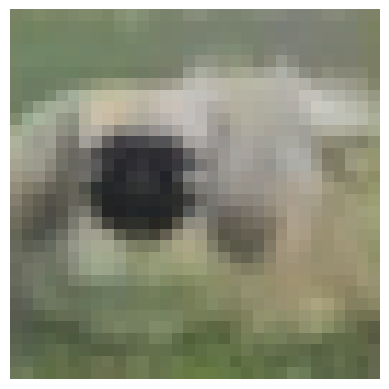

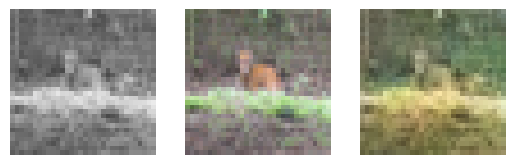

33 / 25033


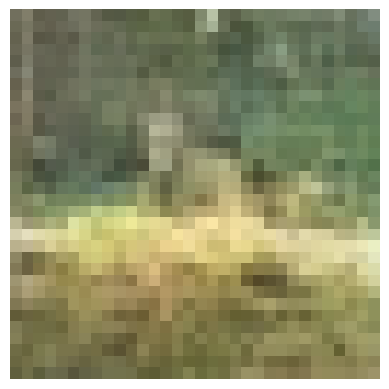

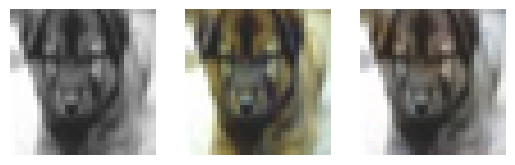

34 / 25034


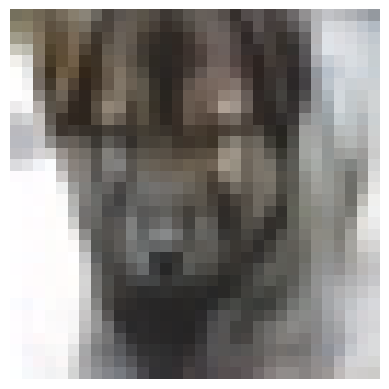

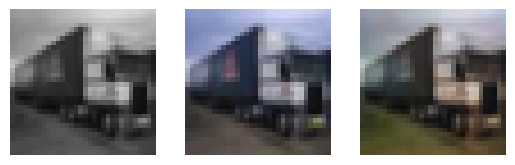

35 / 25035


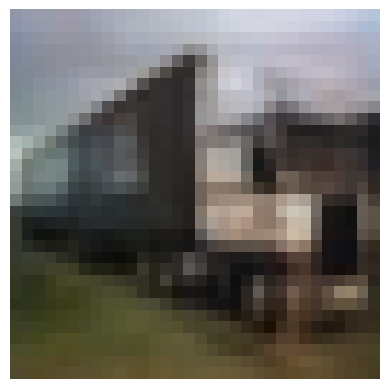

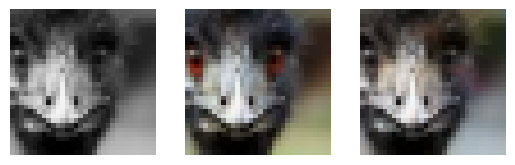

36 / 25036


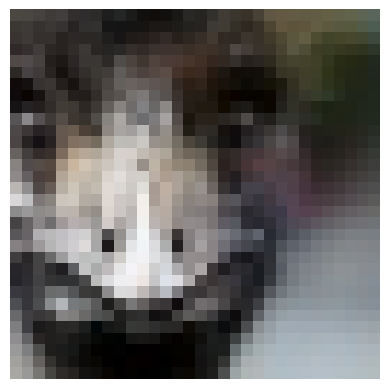

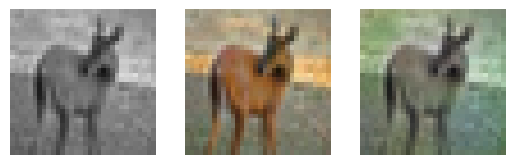

37 / 25037


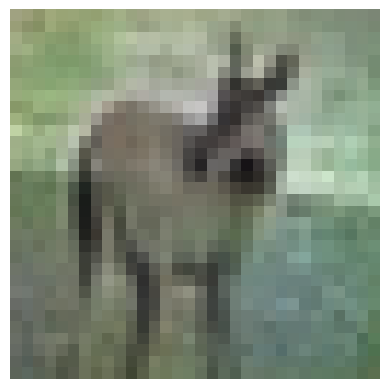

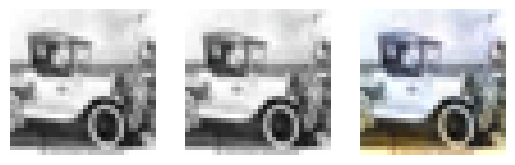

38 / 25038


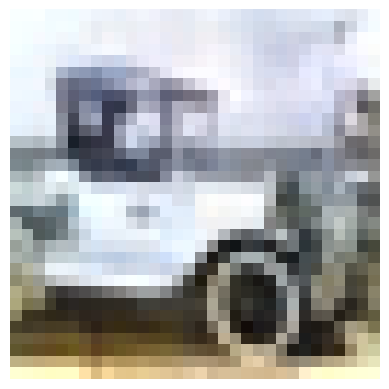

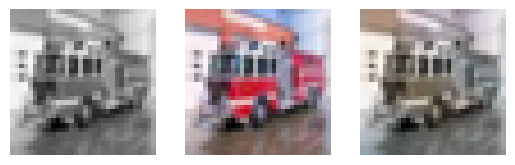

39 / 25039


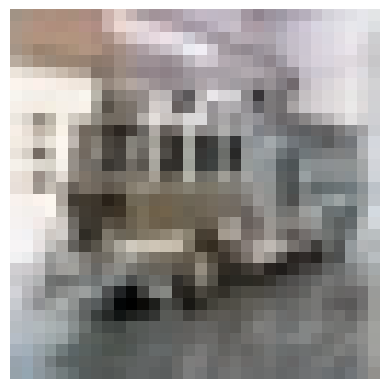

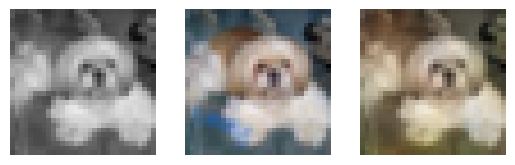

40 / 25040


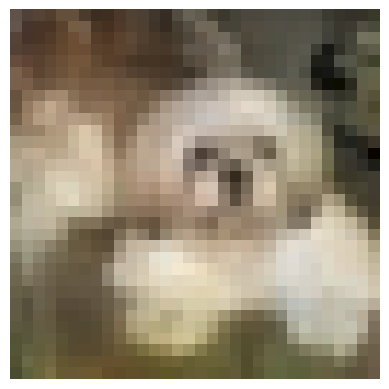

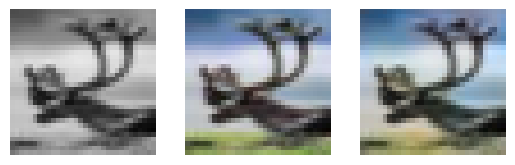

41 / 25041


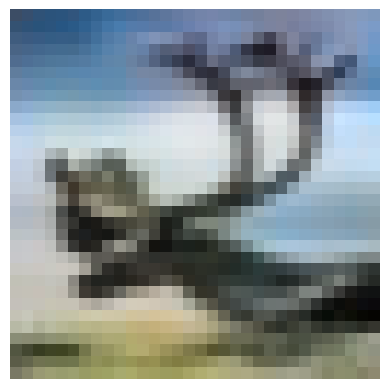

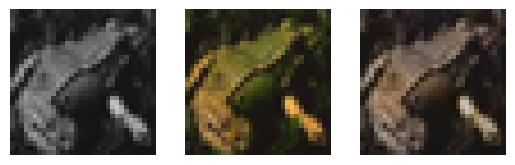

42 / 25042


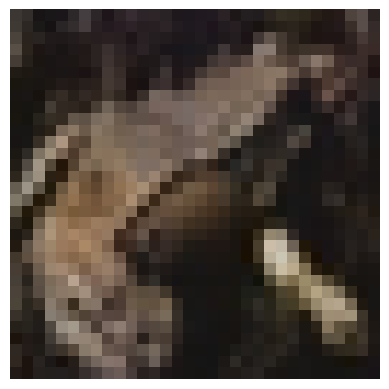

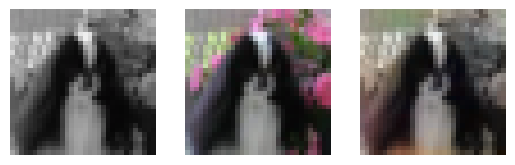

43 / 25043


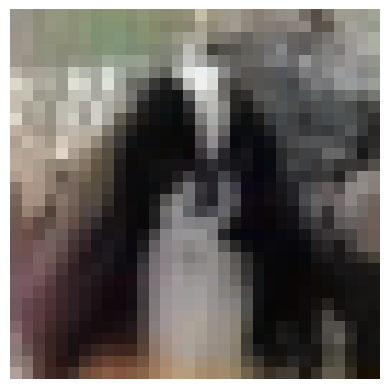

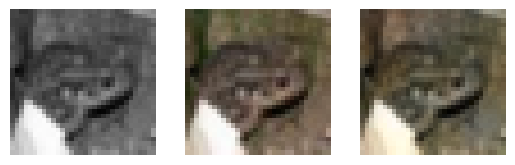

44 / 25044


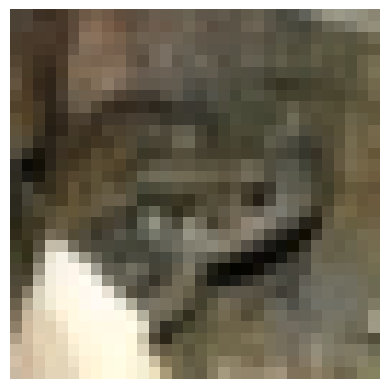

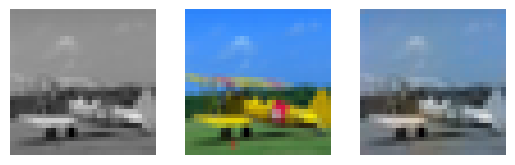

45 / 25045


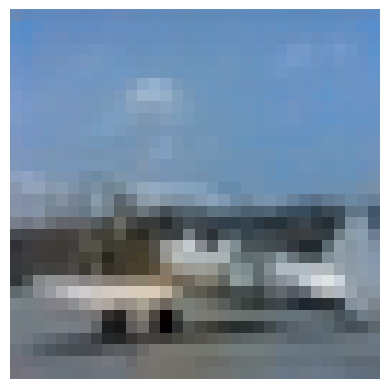

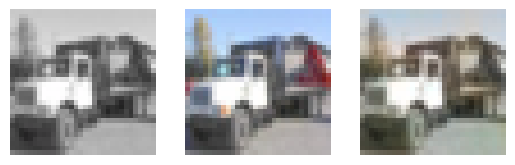

46 / 25046


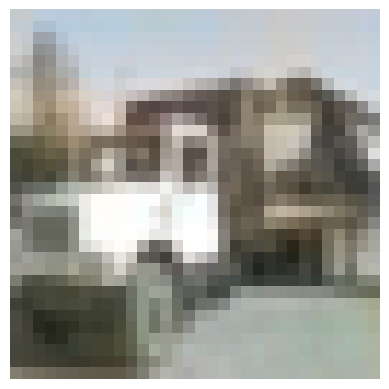

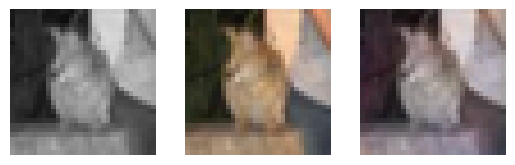

47 / 25047


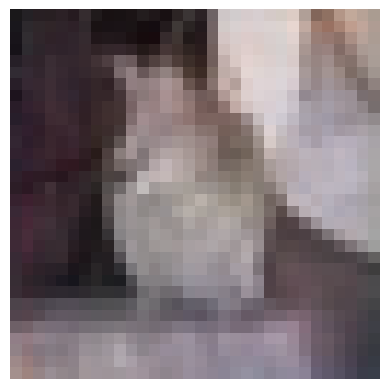

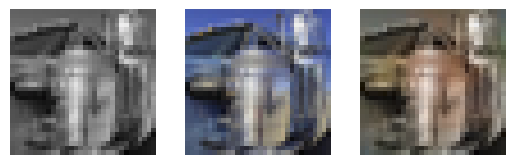

48 / 25048


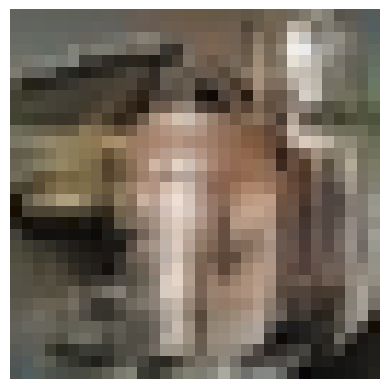

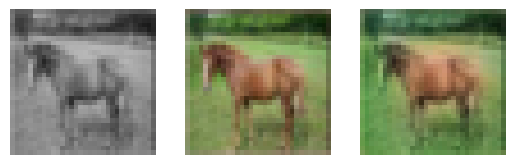

49 / 25049


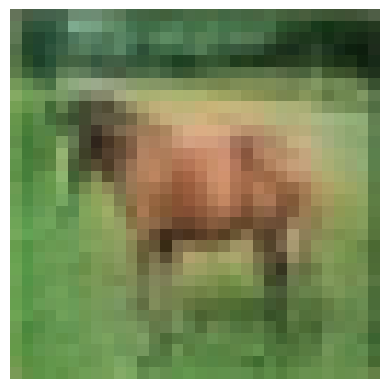

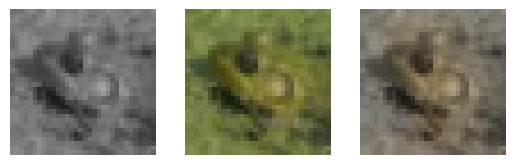

50 / 25050


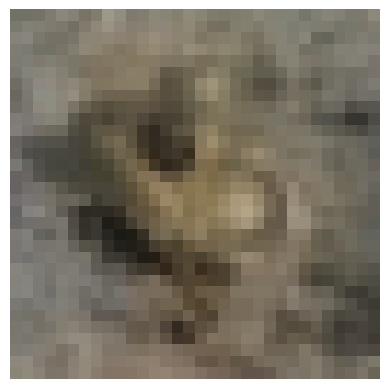

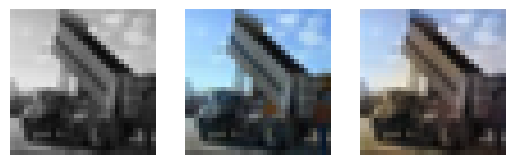

51 / 25051


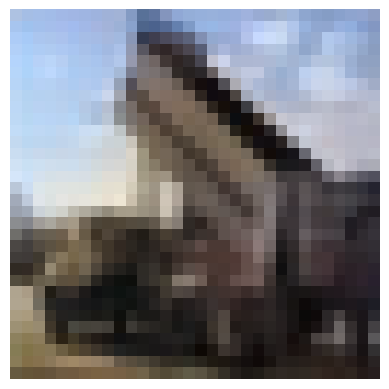

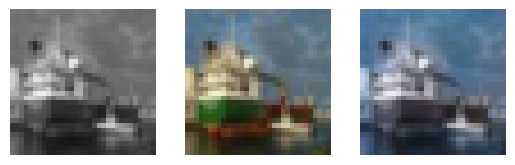

52 / 25052


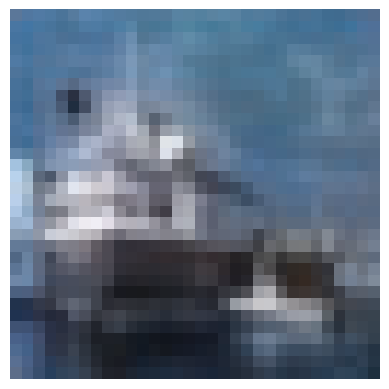

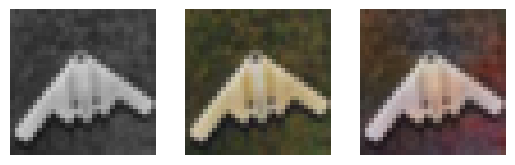

53 / 25053


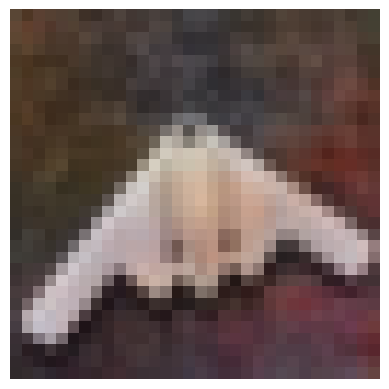

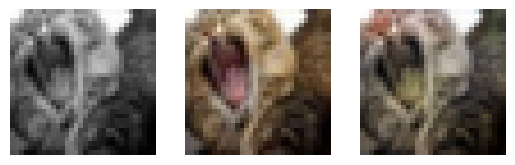

54 / 25054


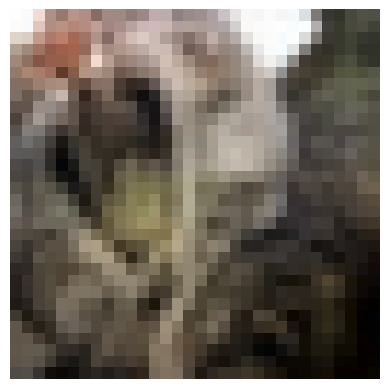

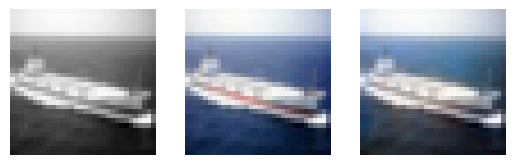

55 / 25055


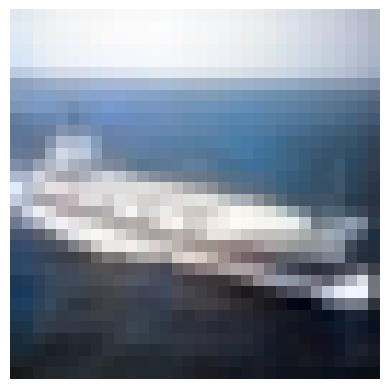

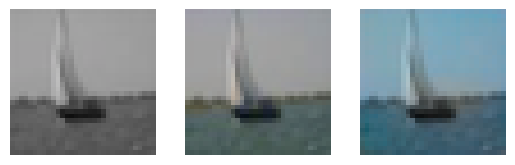

56 / 25056


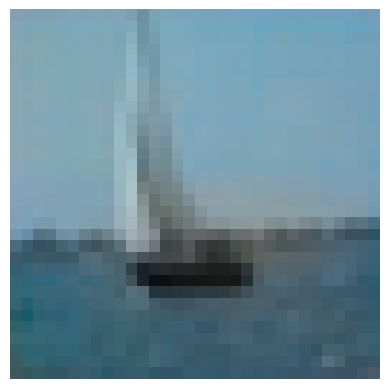

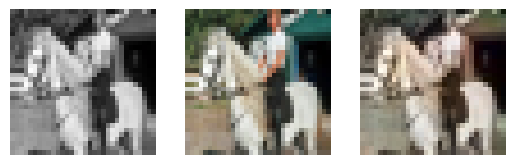

57 / 25057


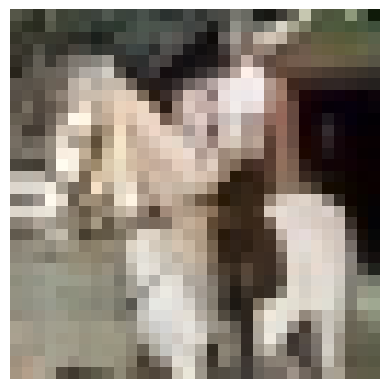

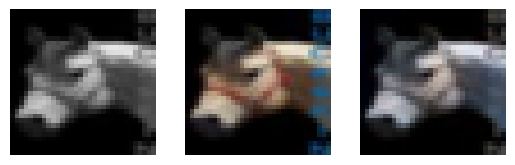

58 / 25058


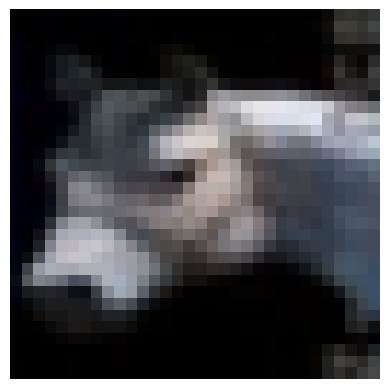

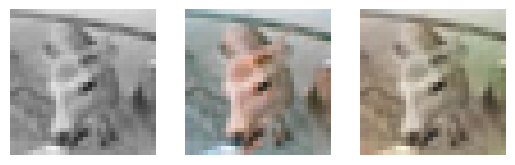

59 / 25059


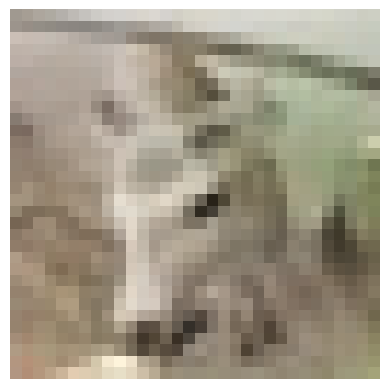

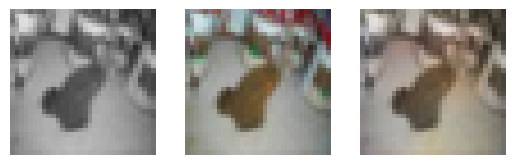

60 / 25060


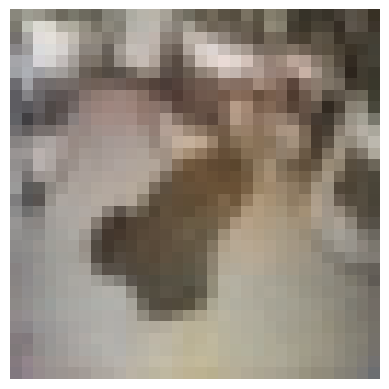

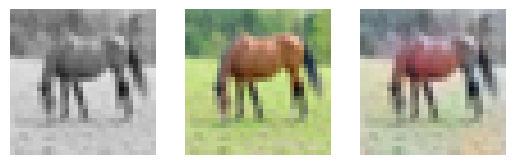

61 / 25061


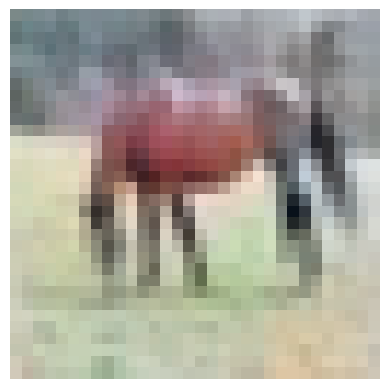

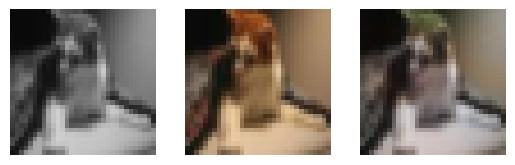

62 / 25062


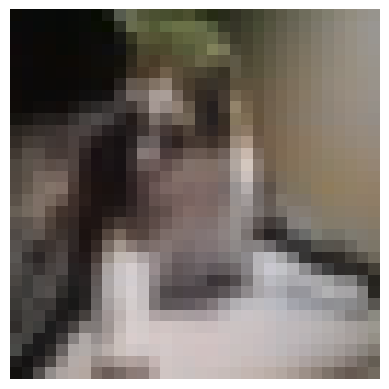

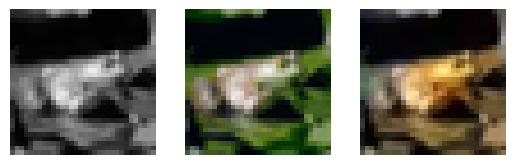

63 / 25063


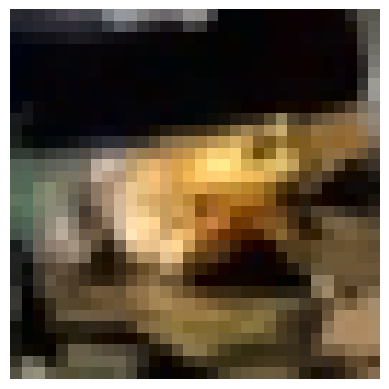

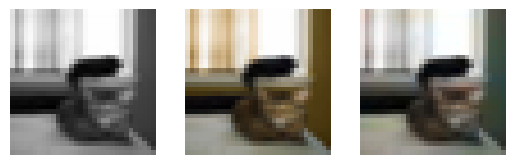

64 / 25064


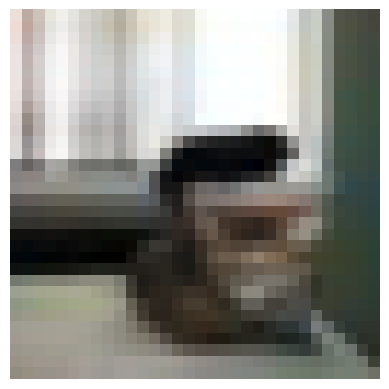

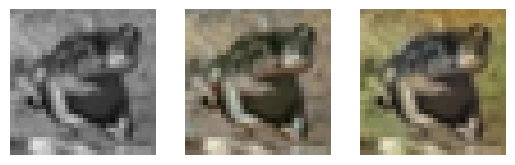

65 / 25065


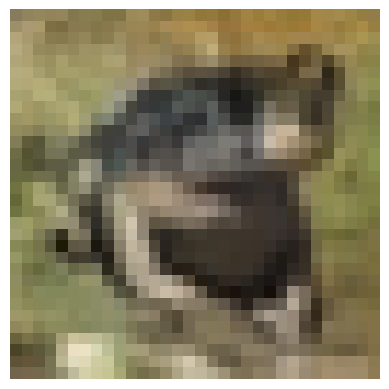

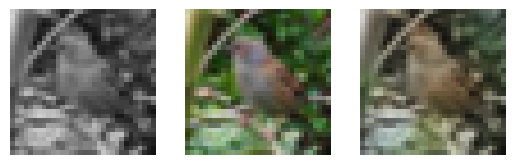

66 / 25066


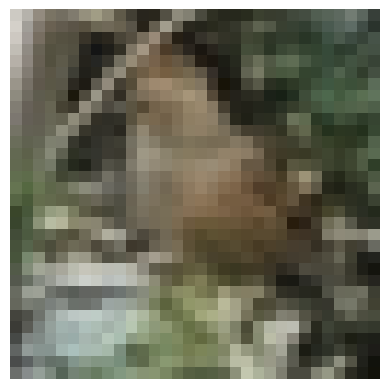

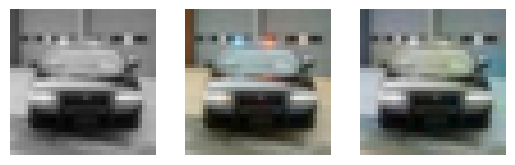

67 / 25067


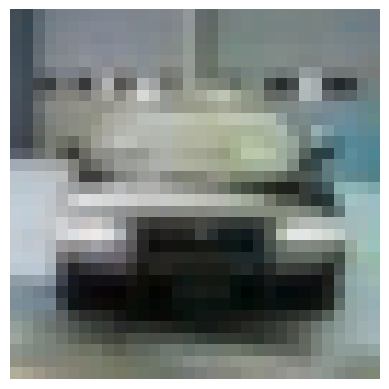

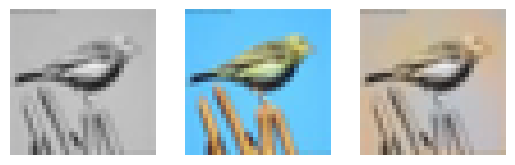

68 / 25068


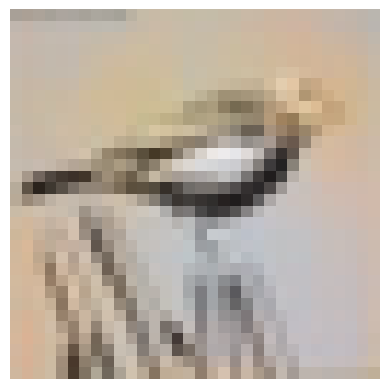

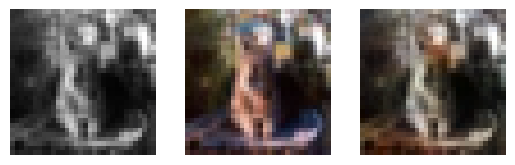

69 / 25069


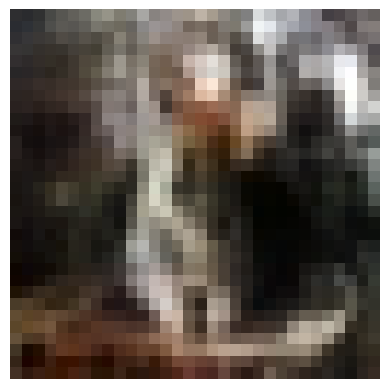

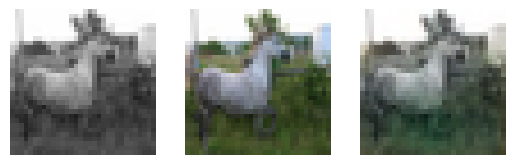

70 / 25070


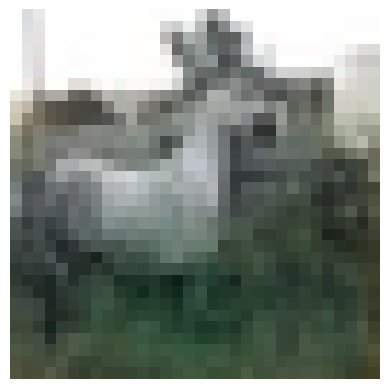

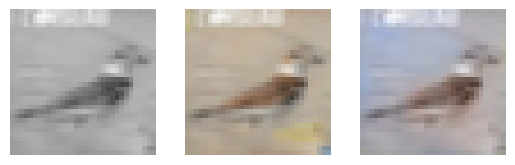

71 / 25071


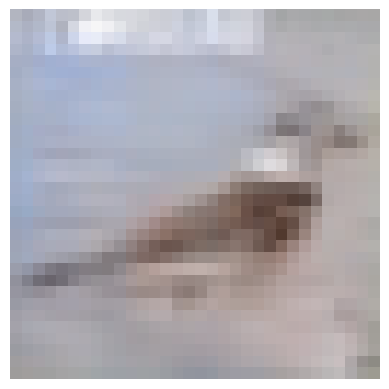

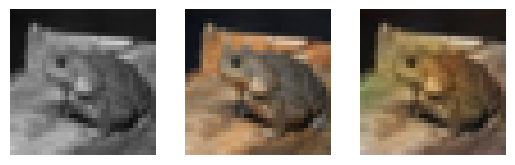

72 / 25072


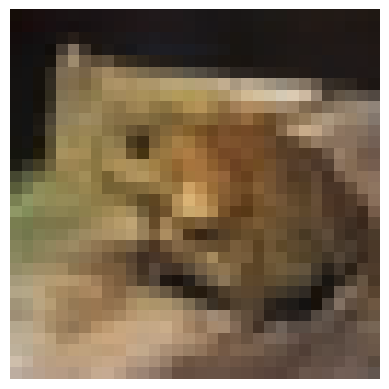

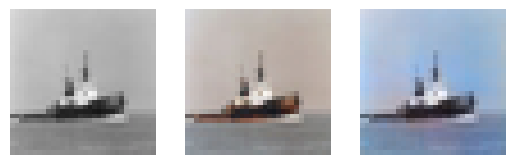

73 / 25073


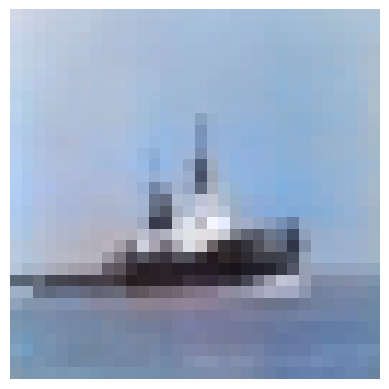

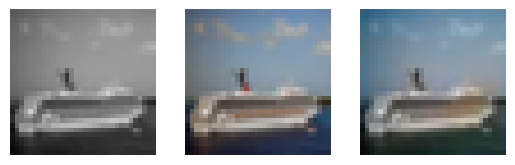

74 / 25074


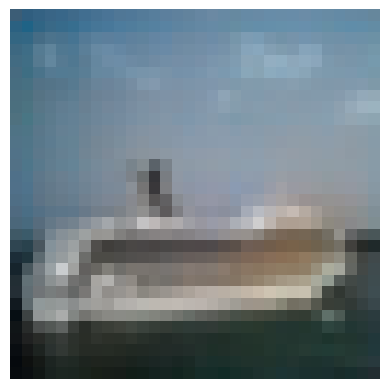

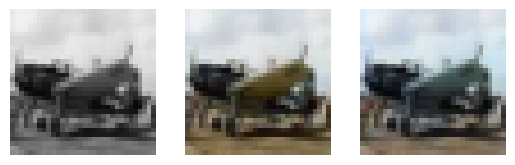

75 / 25075


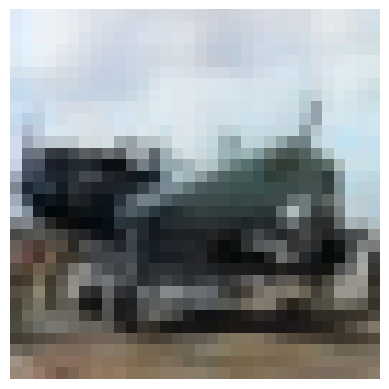

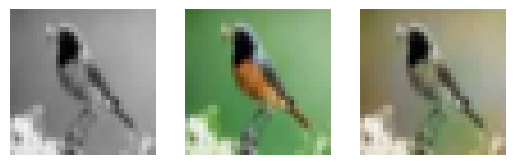

76 / 25076


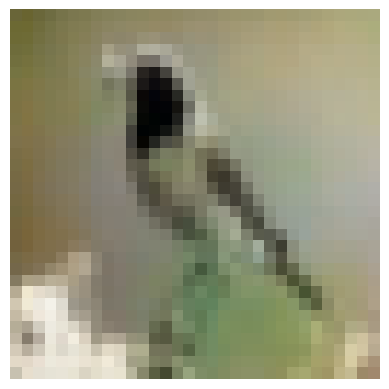

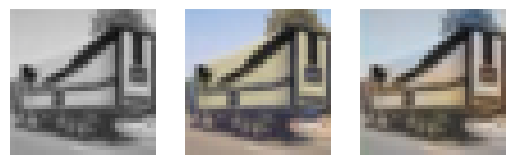

77 / 25077


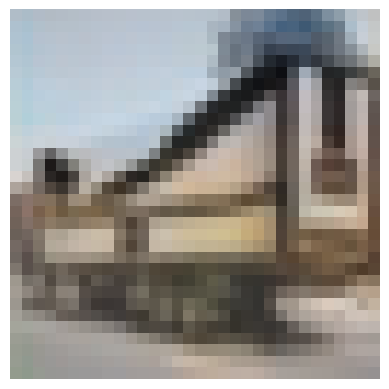

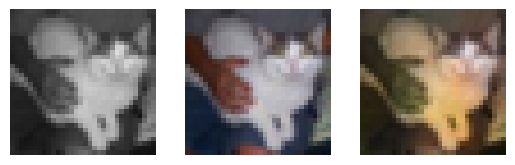

78 / 25078


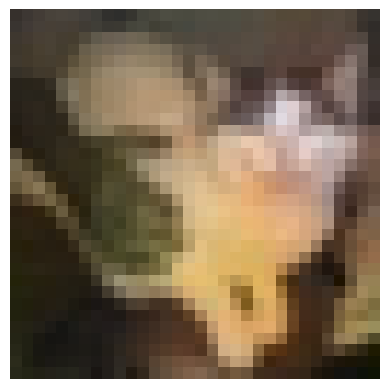

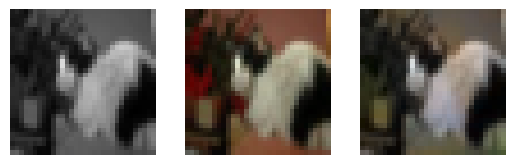

79 / 25079


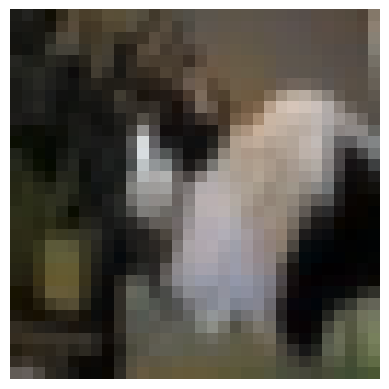

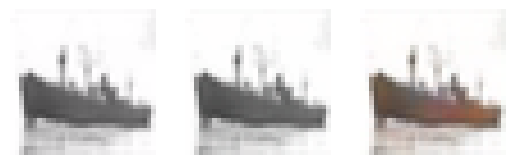

80 / 25080


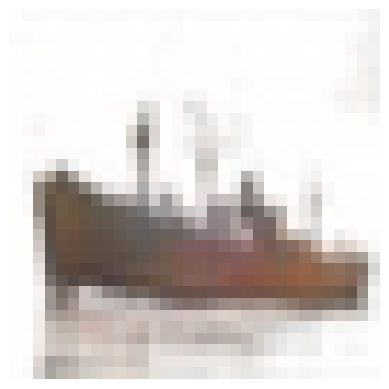

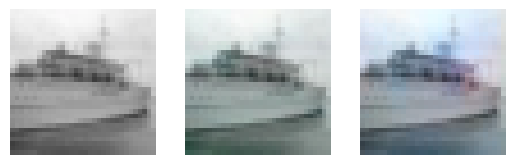

81 / 25081


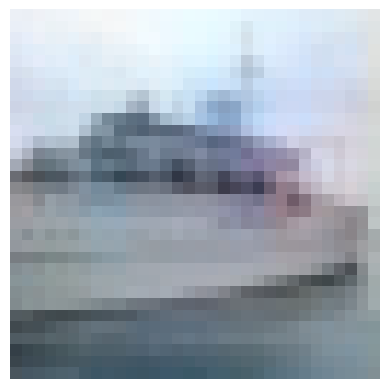

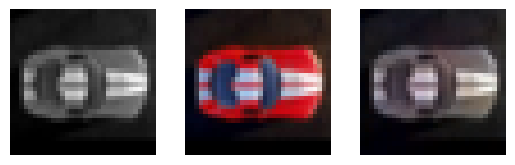

82 / 25082


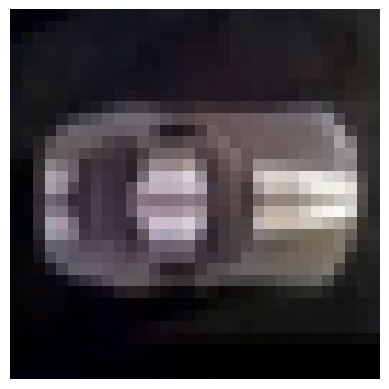

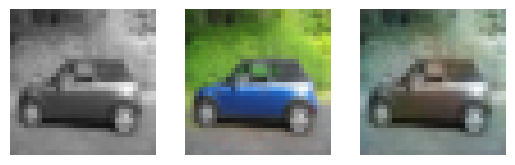

83 / 25083


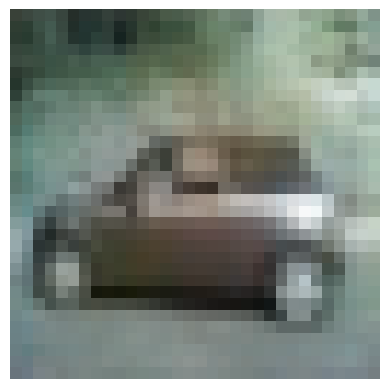

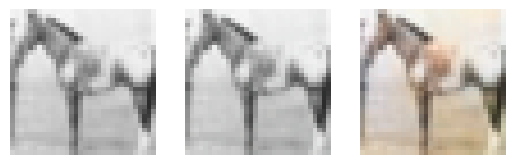

84 / 25084


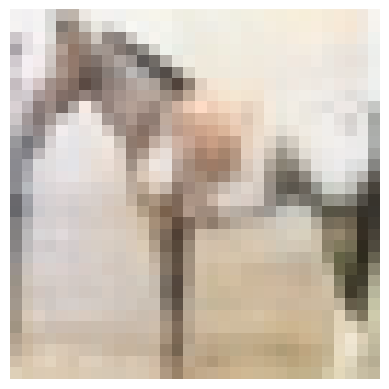

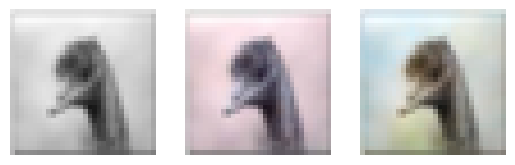

85 / 25085


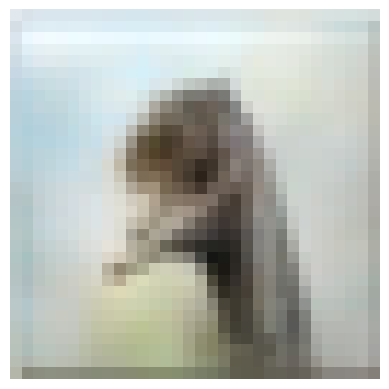

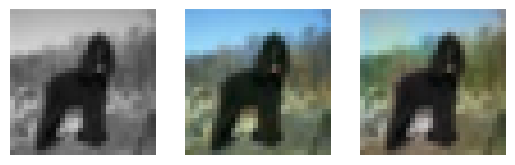

86 / 25086


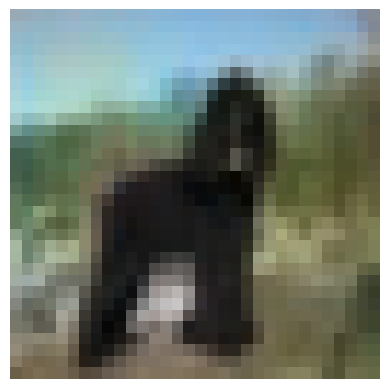

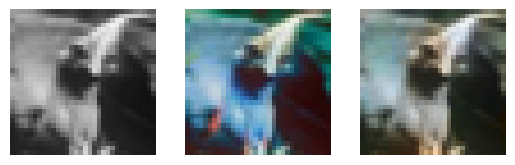

87 / 25087


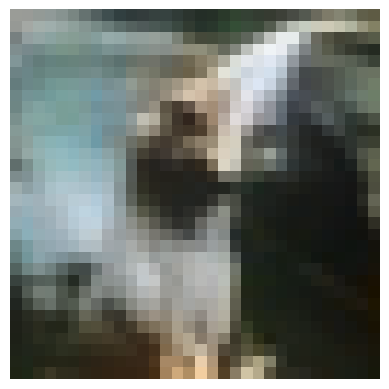

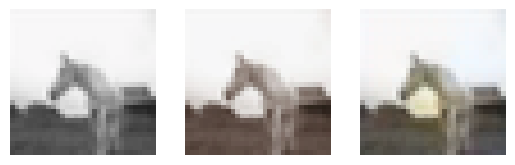

88 / 25088


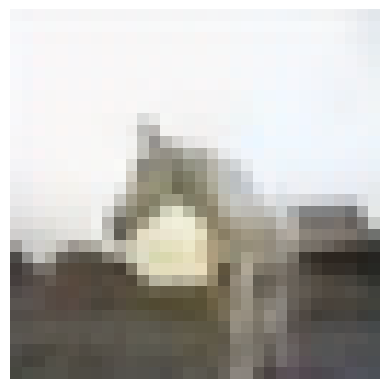

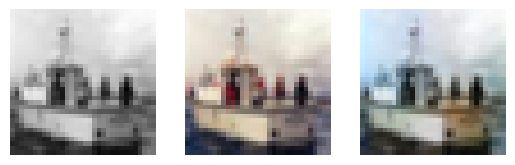

89 / 25089


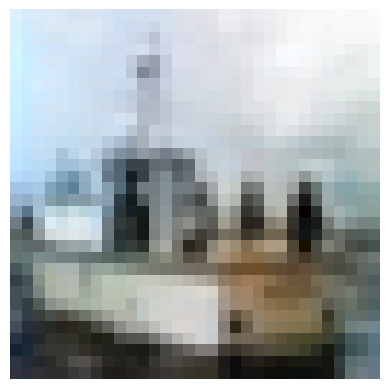

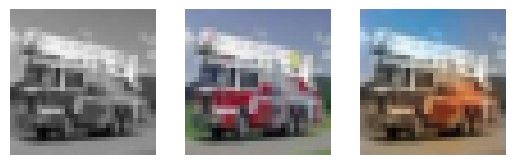

90 / 25090


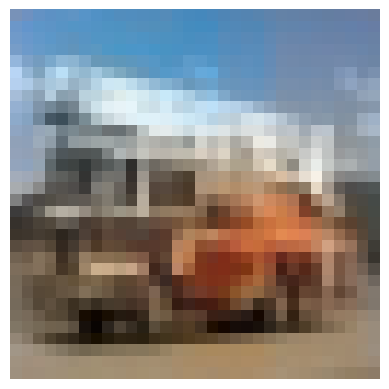

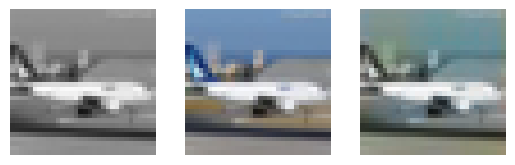

91 / 25091


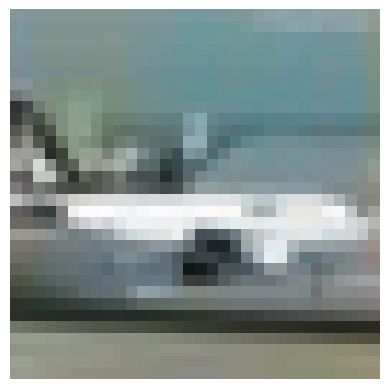

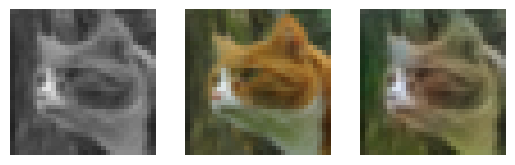

92 / 25092


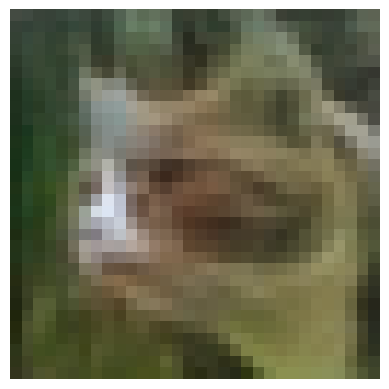

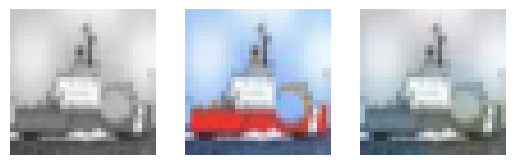

93 / 25093


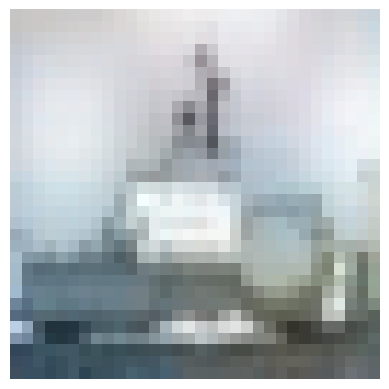

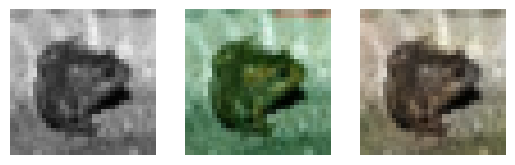

94 / 25094


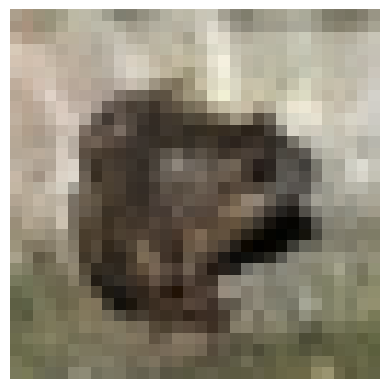

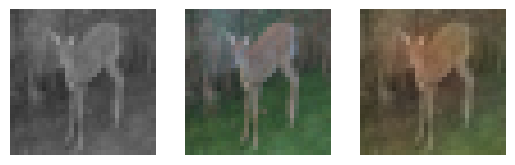

95 / 25095


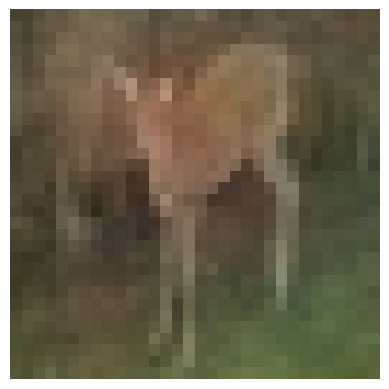

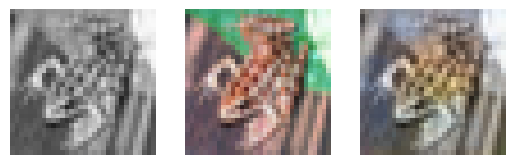

96 / 25096


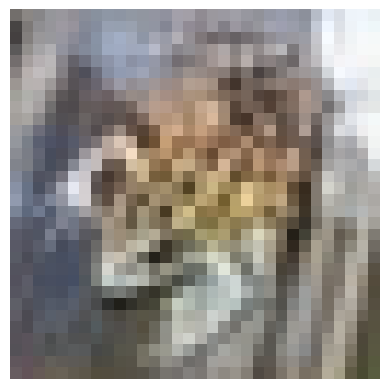

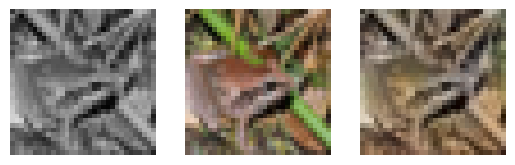

97 / 25097


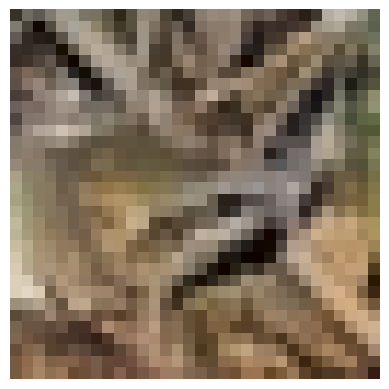

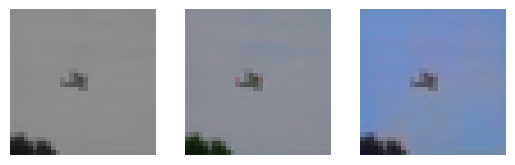

98 / 25098


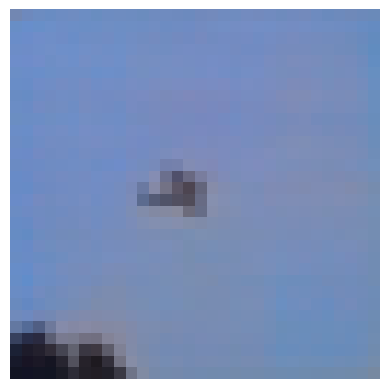

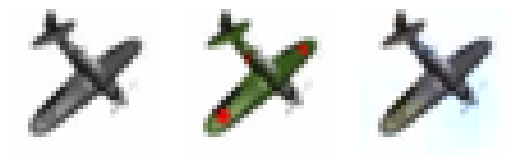

99 / 25099


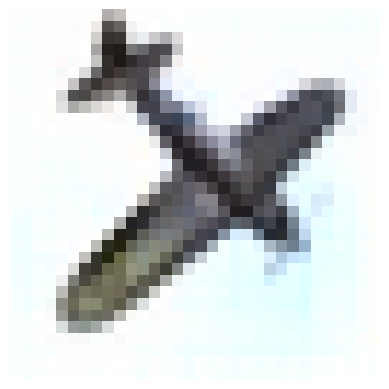

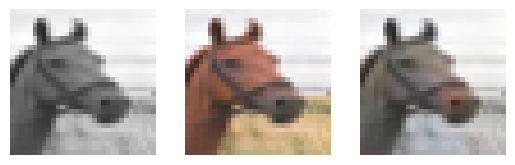

100 / 250100


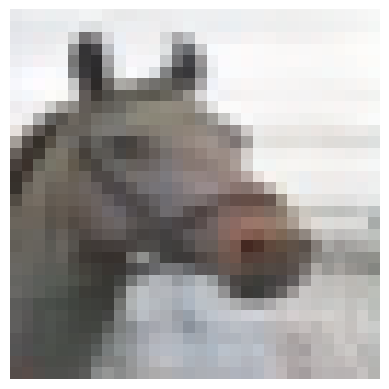

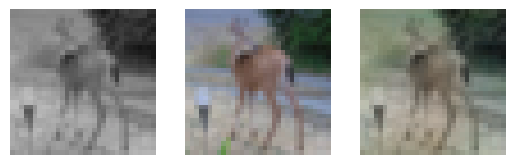

101 / 250101


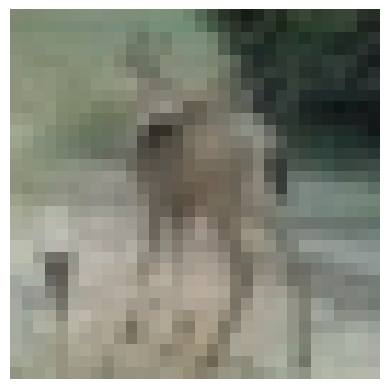

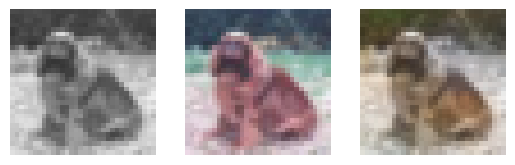

102 / 250102


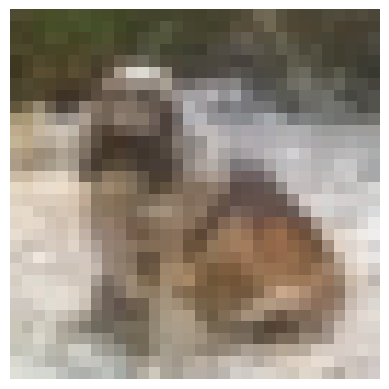

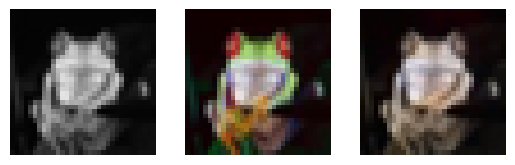

103 / 250103


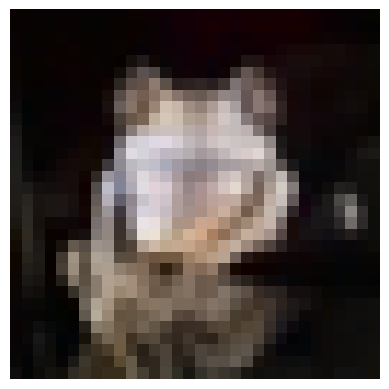

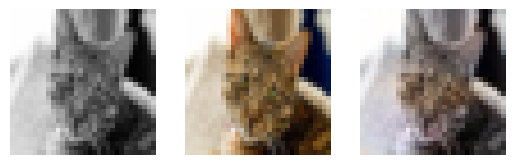

104 / 250104


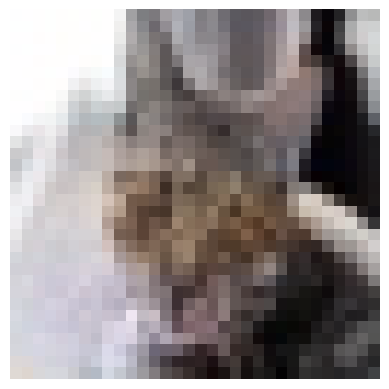

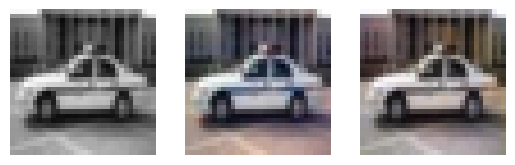

105 / 250105


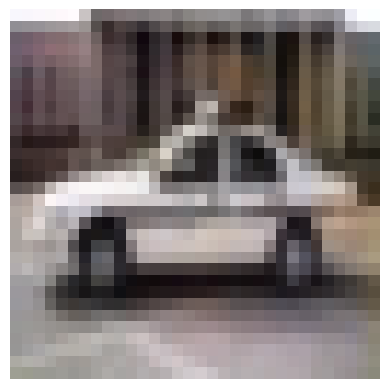

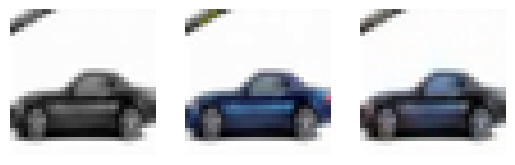

106 / 250106


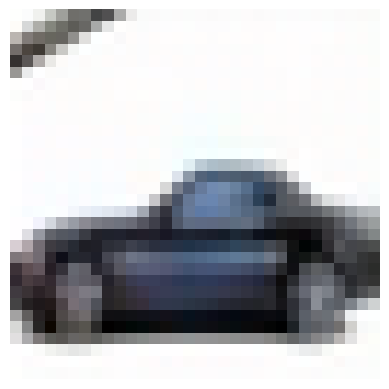

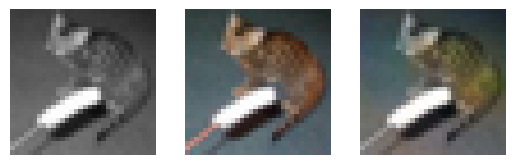

107 / 250107


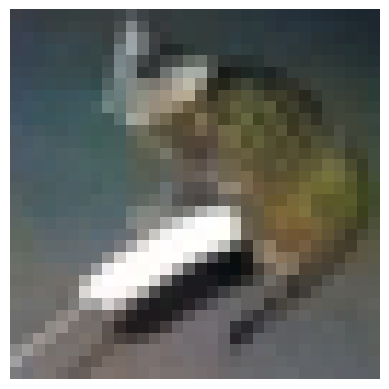

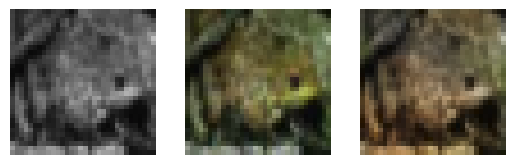

108 / 250108


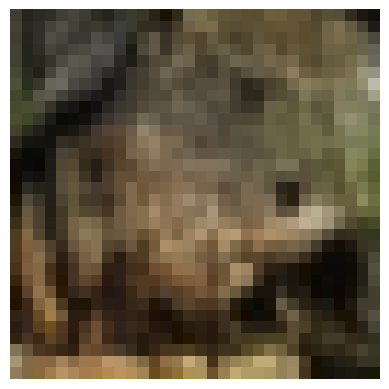

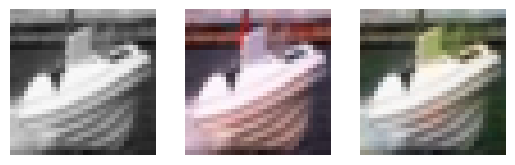

109 / 250109


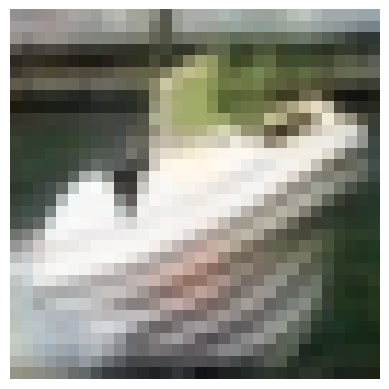

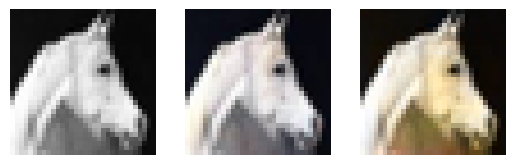

110 / 250110


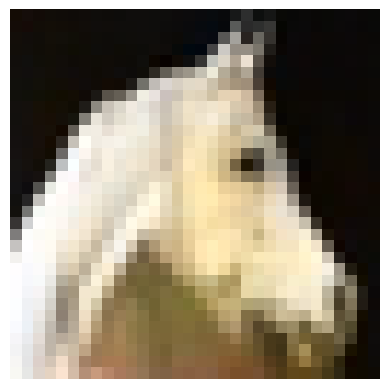

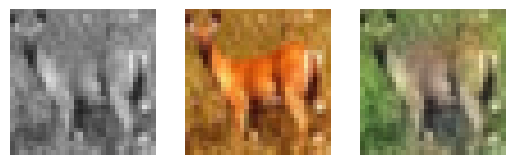

111 / 250111


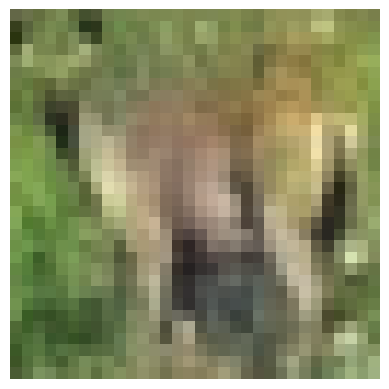

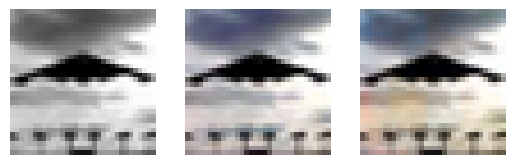

112 / 250112


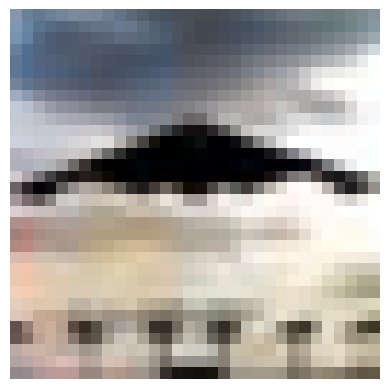

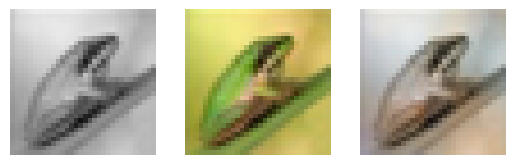

113 / 250113


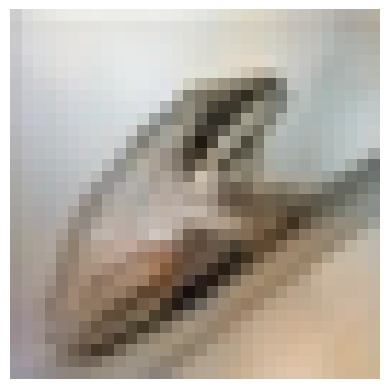

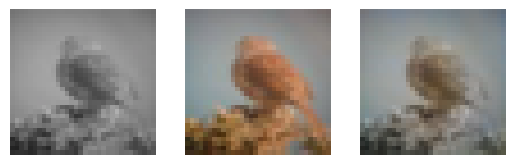

114 / 250114


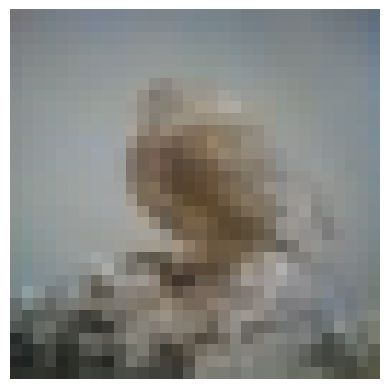

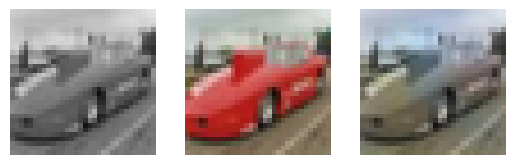

115 / 250115


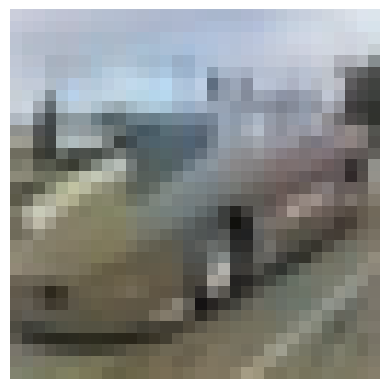

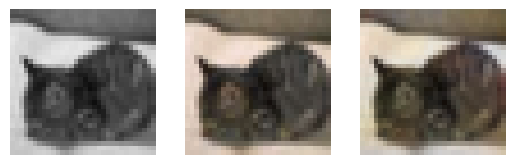

116 / 250116


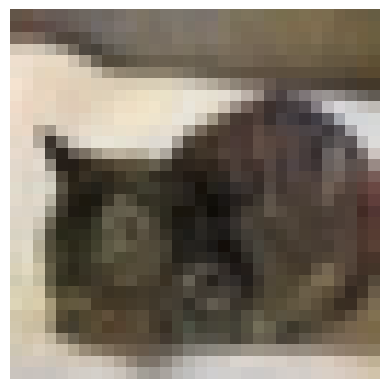

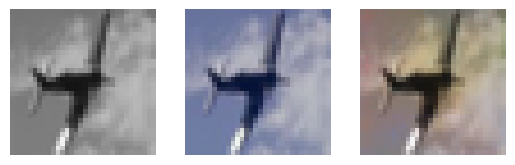

117 / 250117


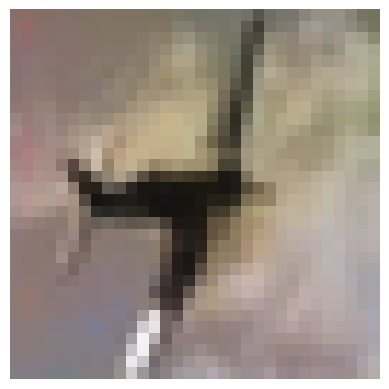

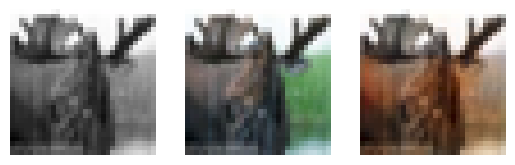

118 / 250118


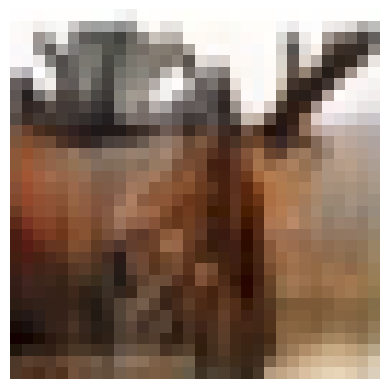

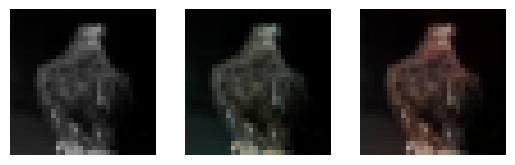

119 / 250119


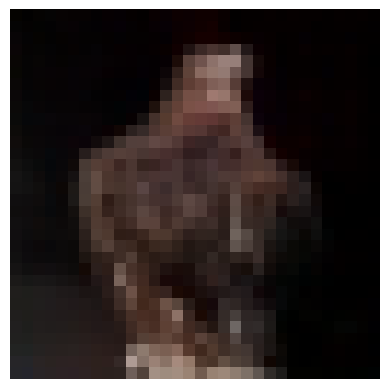

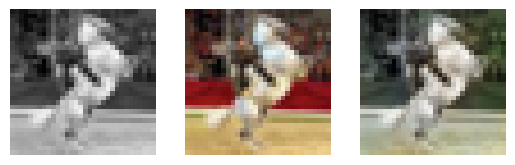

120 / 250120


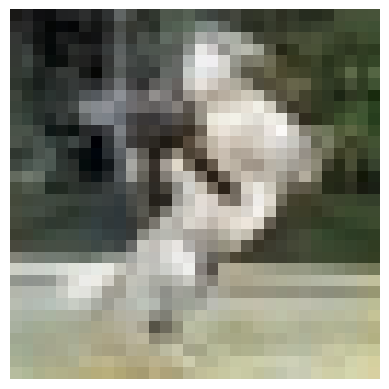

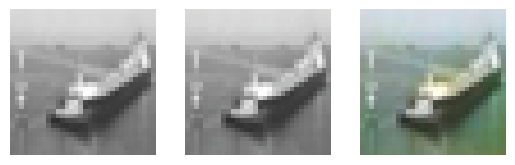

121 / 250121


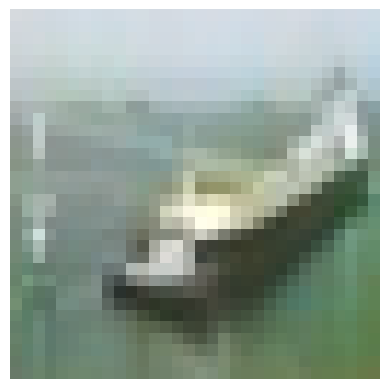

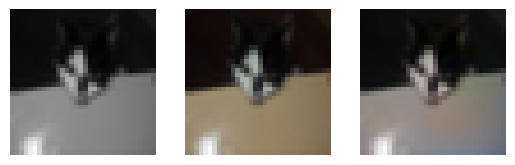

122 / 250122


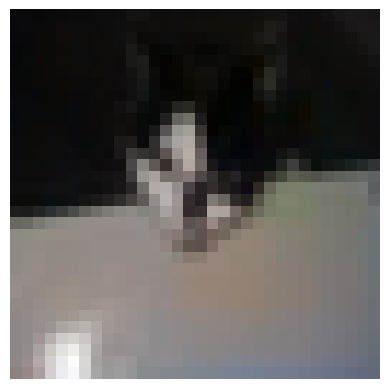

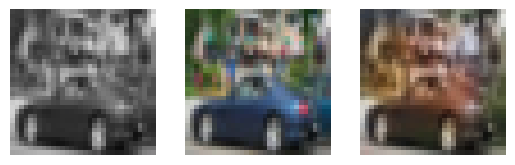

123 / 250123


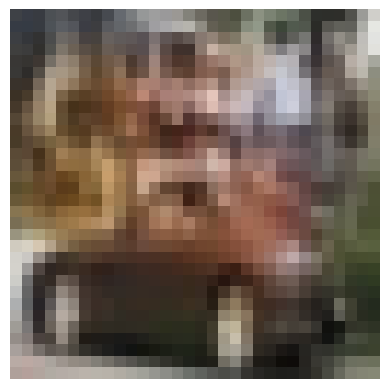

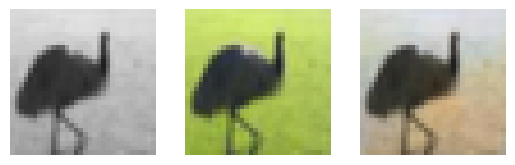

124 / 250124


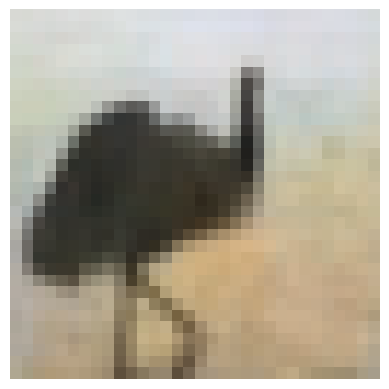

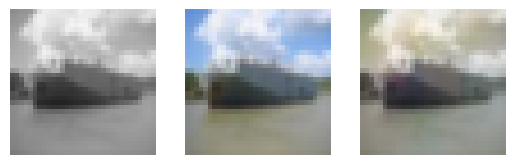

125 / 250125


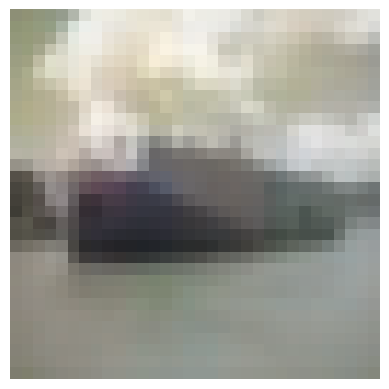

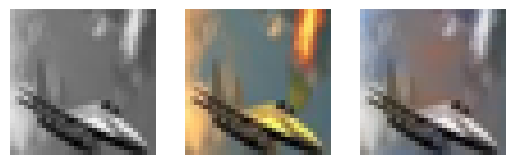

126 / 250126


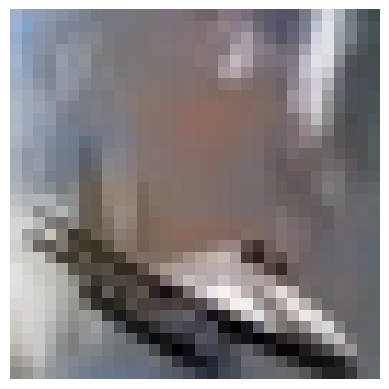

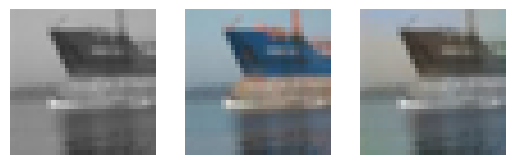

127 / 250127


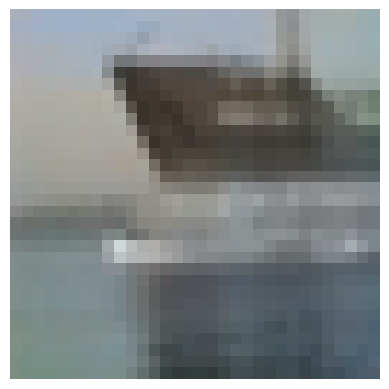

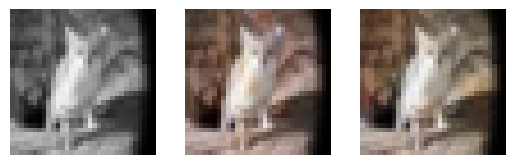

128 / 250128


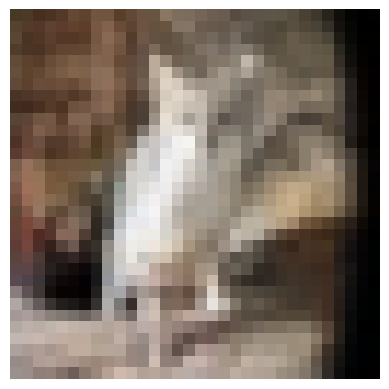

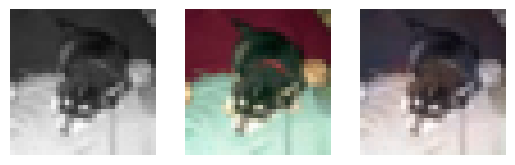

129 / 250129


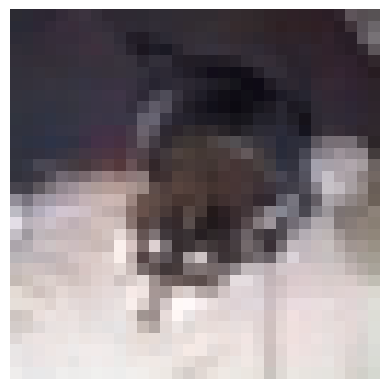

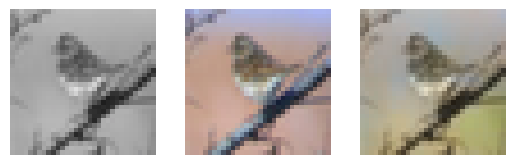

130 / 250130


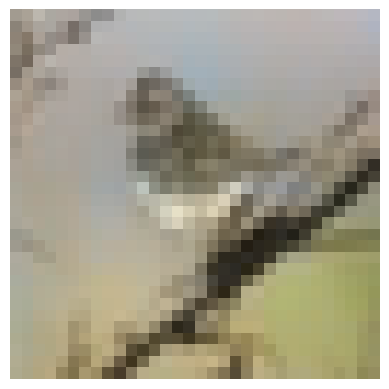

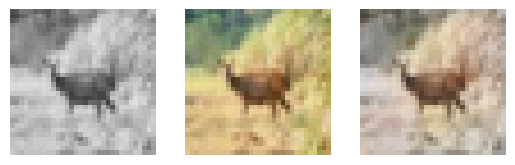

131 / 250131


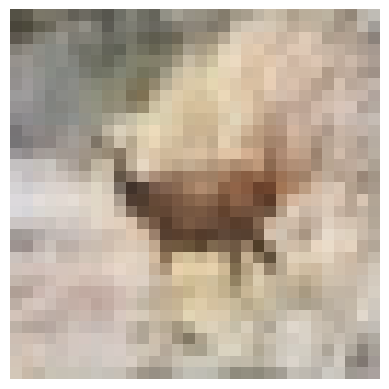

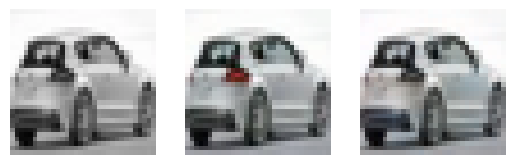

132 / 250132


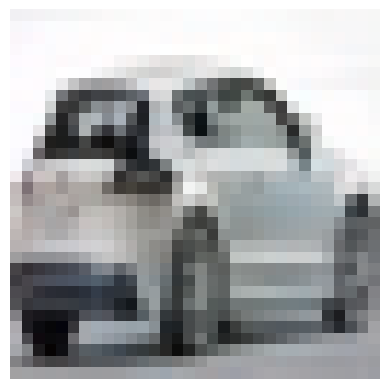

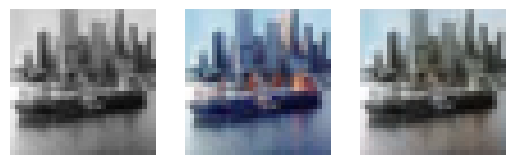

133 / 250133


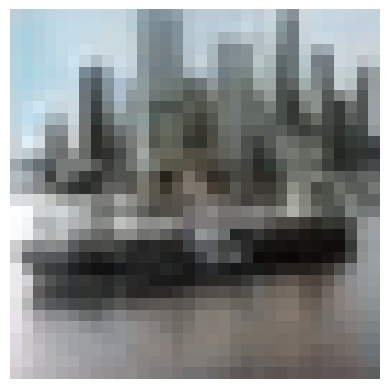

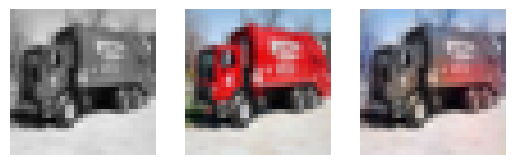

134 / 250134


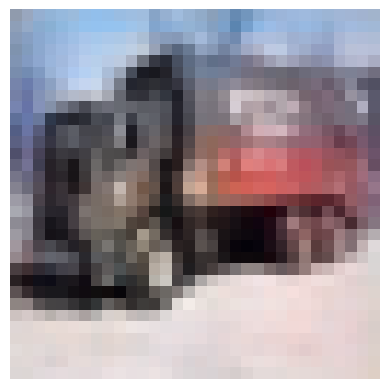

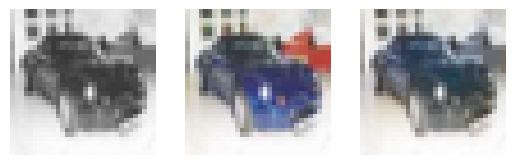

135 / 250135


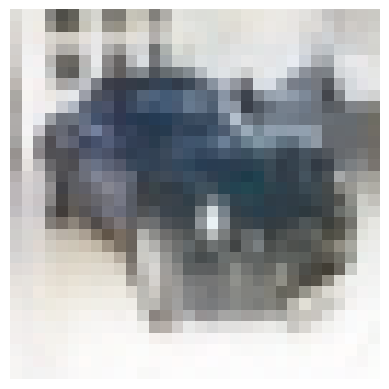

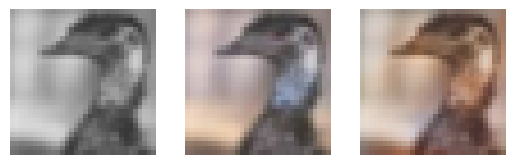

136 / 250136


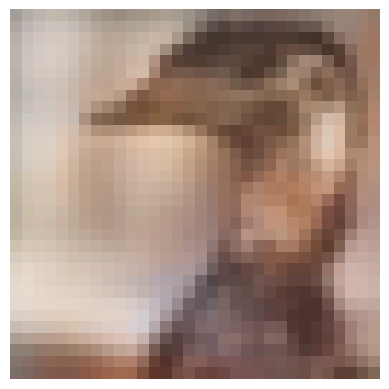

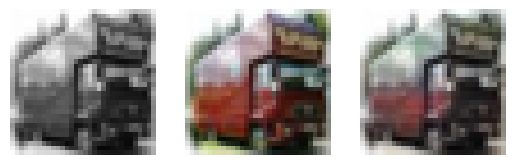

137 / 250137


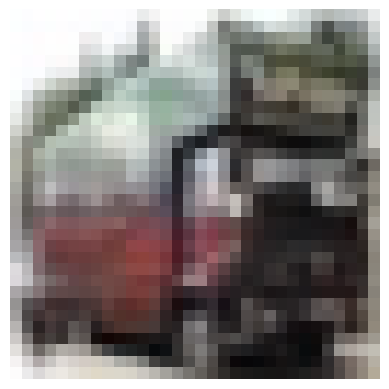

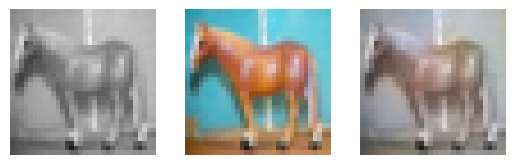

138 / 250138


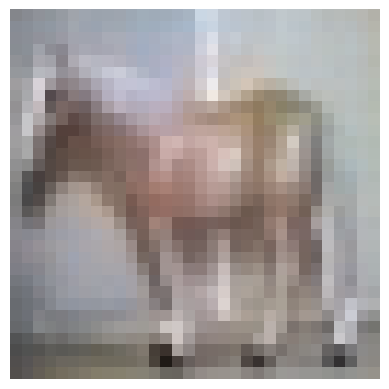

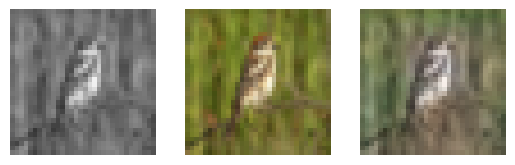

139 / 250139


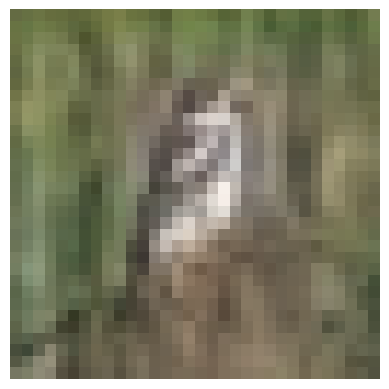

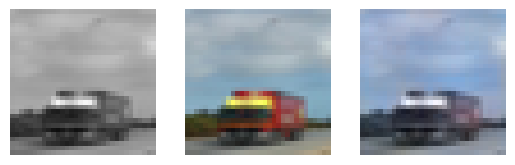

140 / 250140


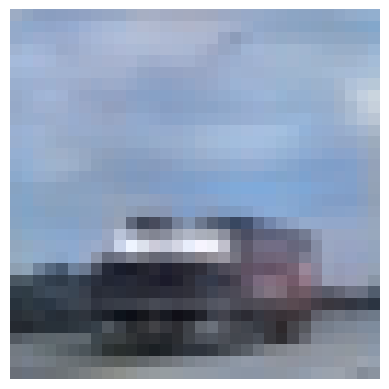

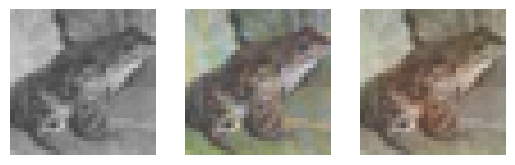

141 / 250141


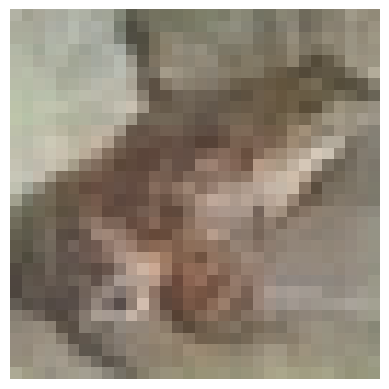

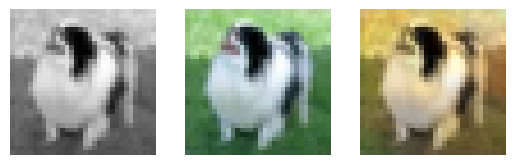

142 / 250142


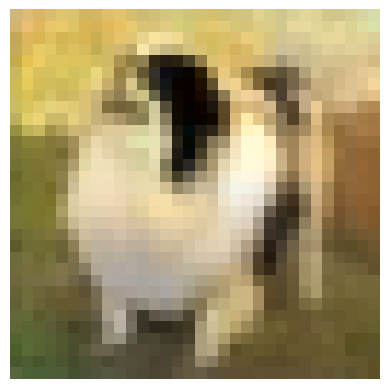

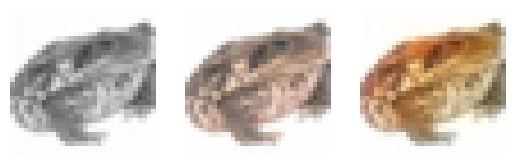

143 / 250143


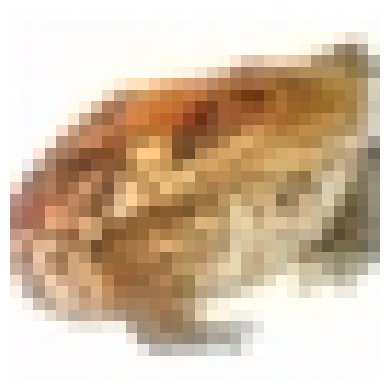

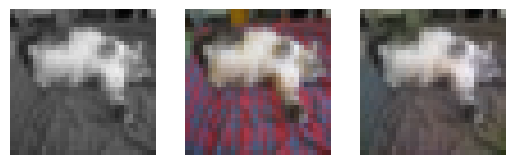

144 / 250144


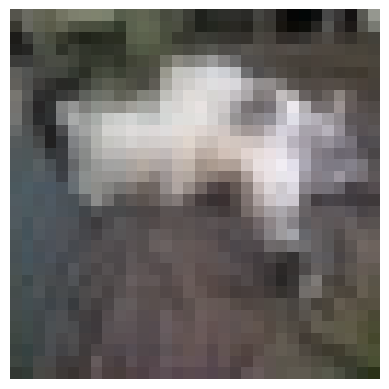

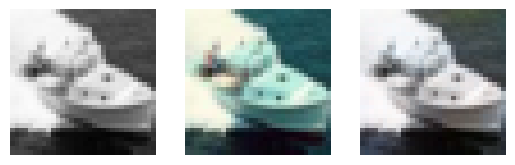

145 / 250145


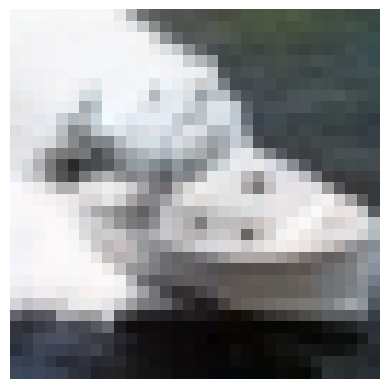

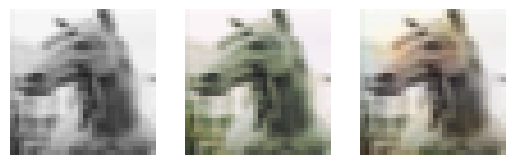

146 / 250146


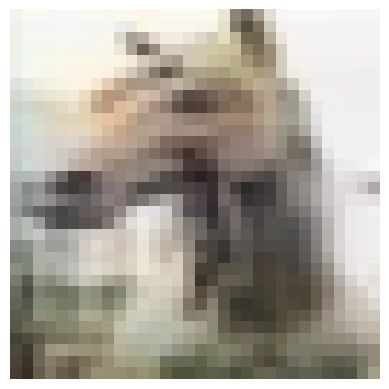

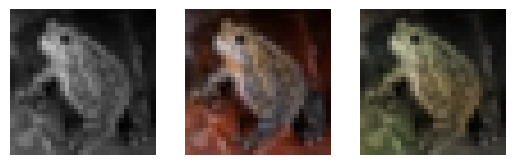

147 / 250147


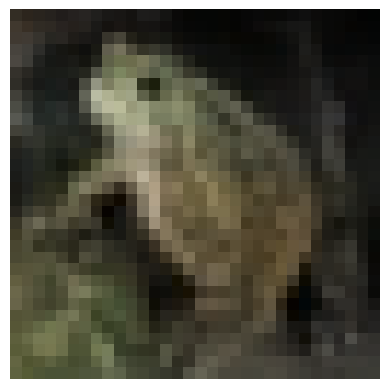

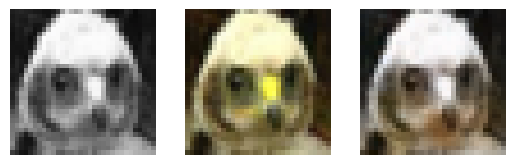

148 / 250148


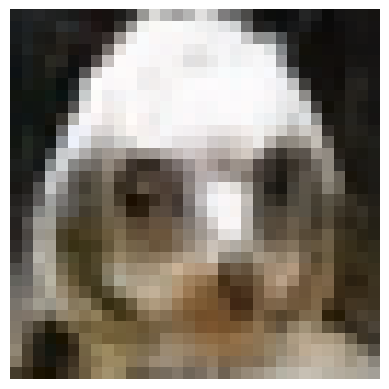

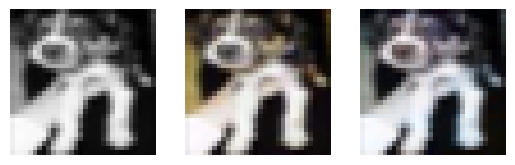

149 / 250149


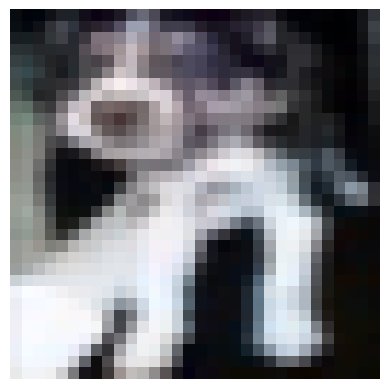

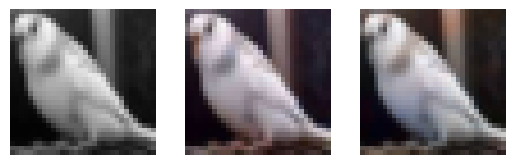

150 / 250150


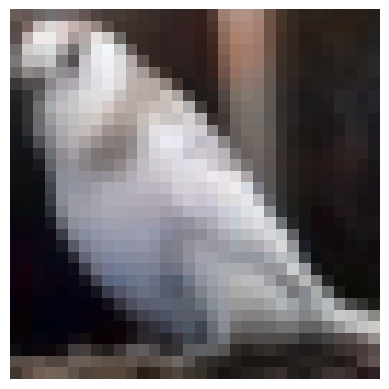

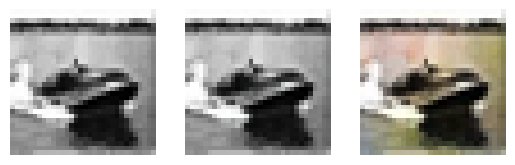

151 / 250151


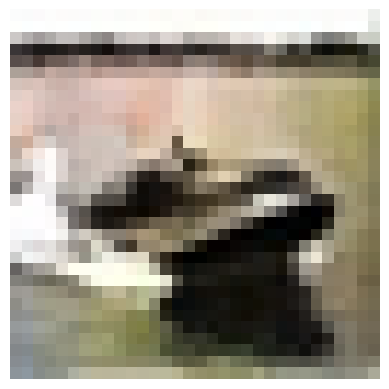

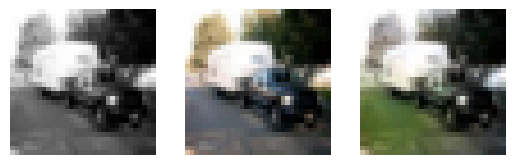

152 / 250152


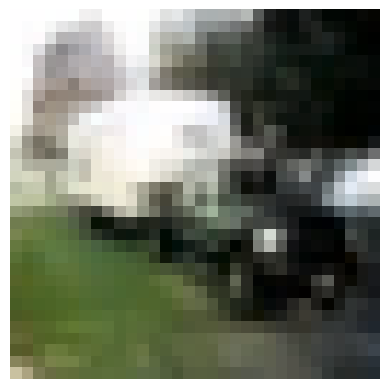

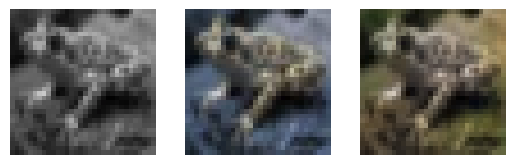

153 / 250153


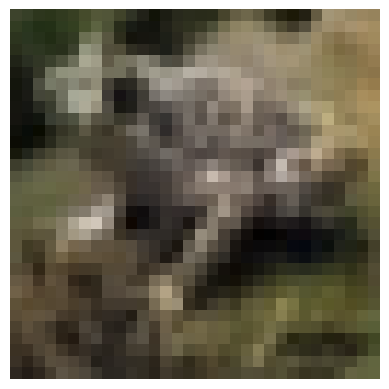

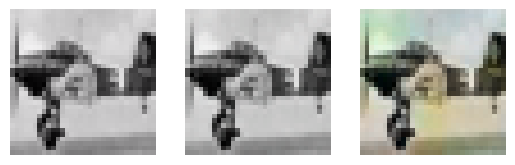

154 / 250154


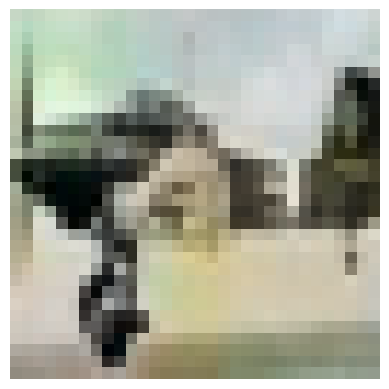

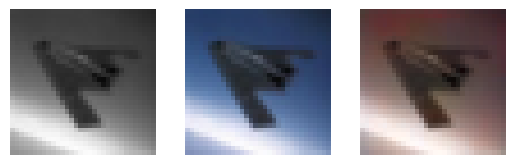

155 / 250155


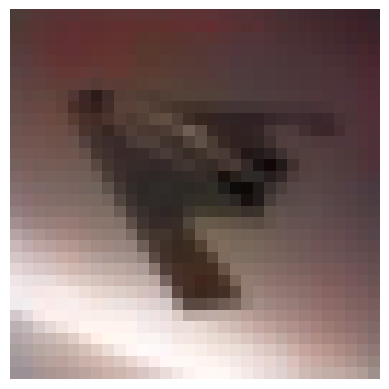

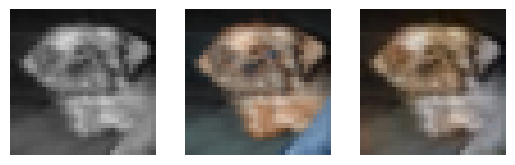

156 / 250156


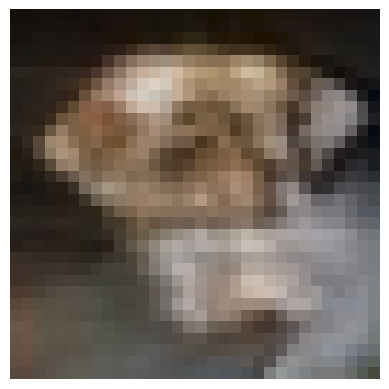

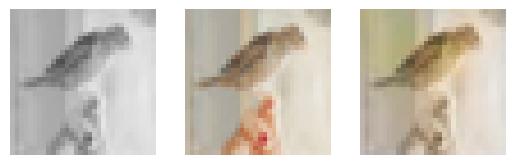

157 / 250157


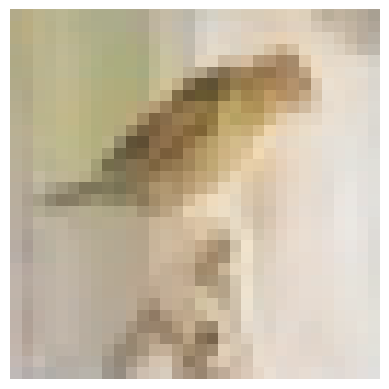

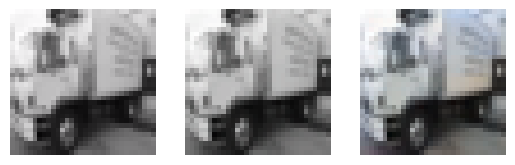

158 / 250158


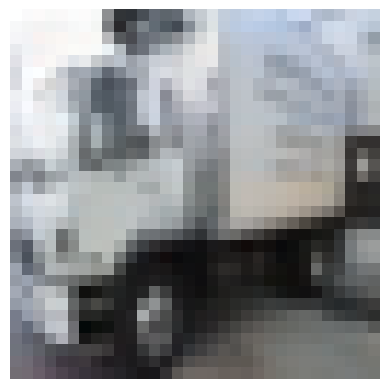

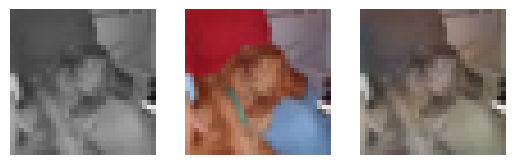

159 / 250159


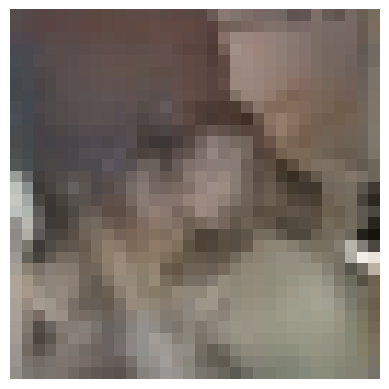

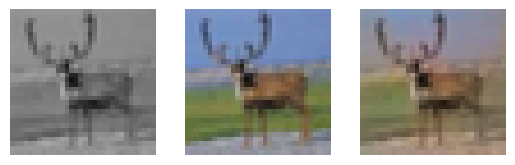

160 / 250160


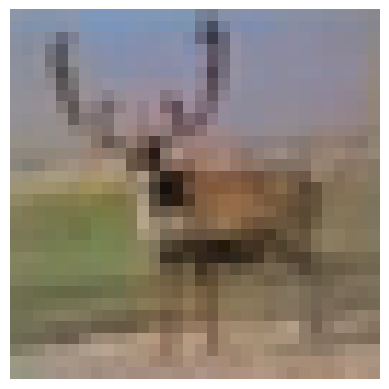

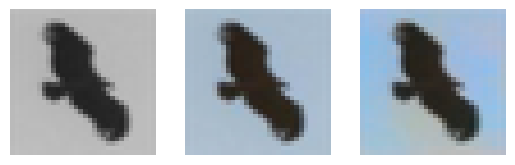

161 / 250161


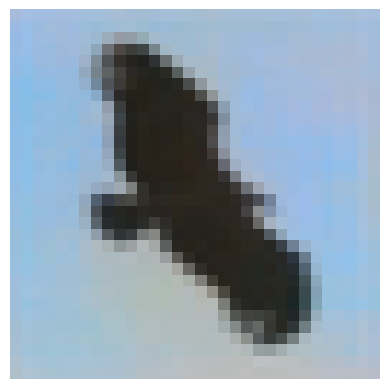

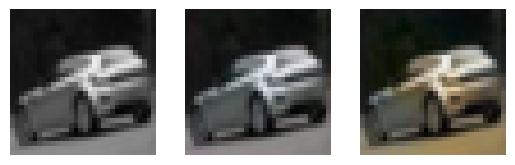

162 / 250162


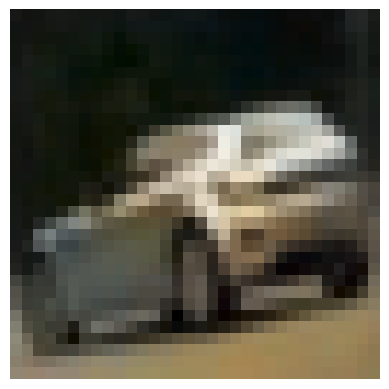

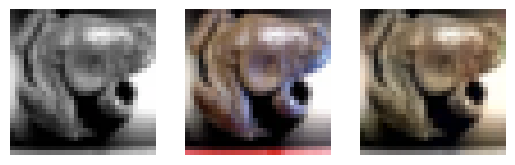

163 / 250163


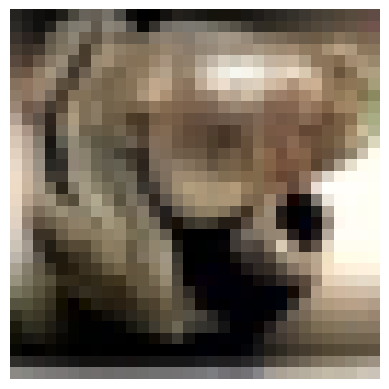

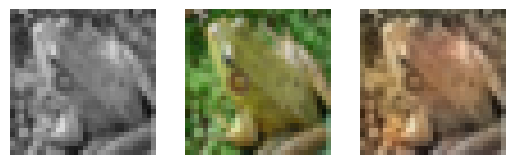

164 / 250164


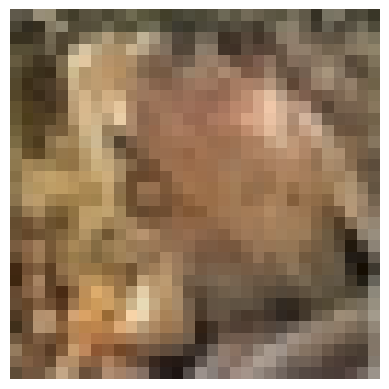

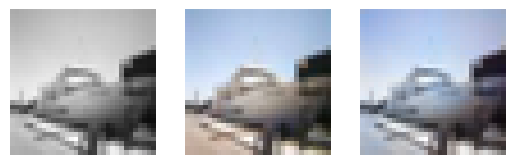

165 / 250165


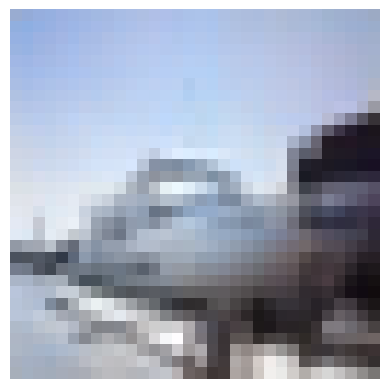

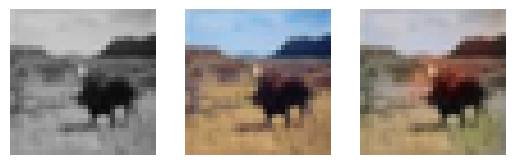

166 / 250166


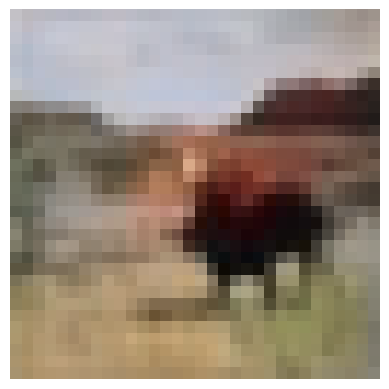

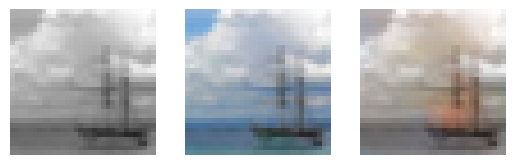

167 / 250167


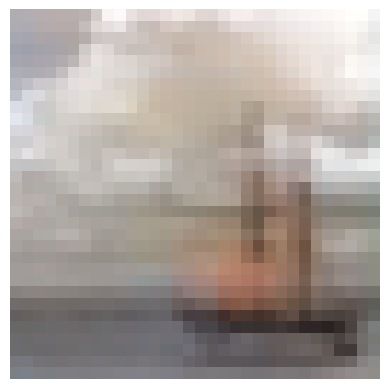

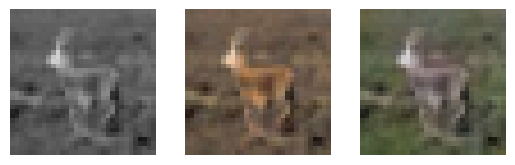

168 / 250168


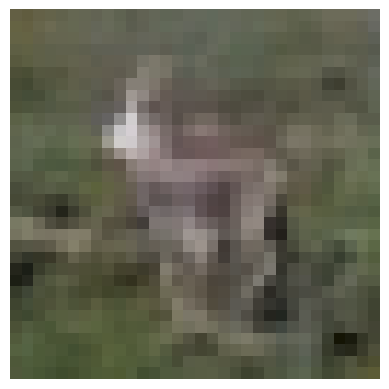

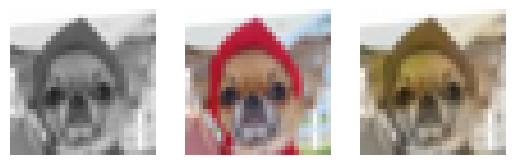

169 / 250169


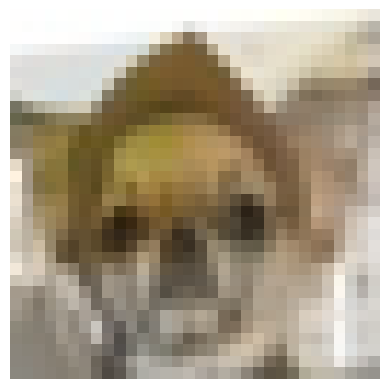

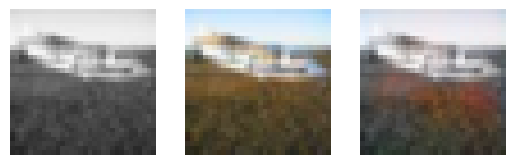

170 / 250170


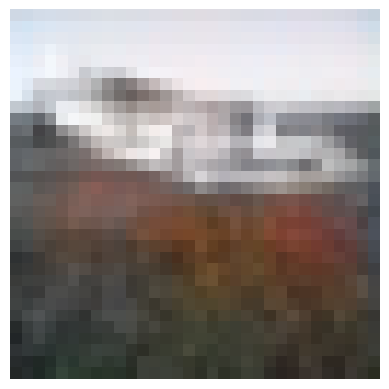

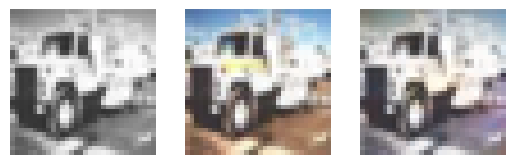

171 / 250171


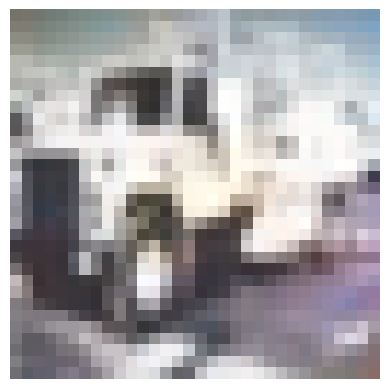

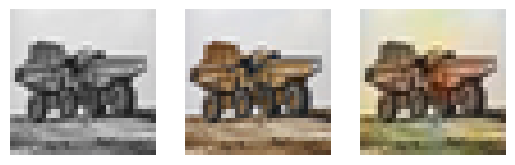

172 / 250172


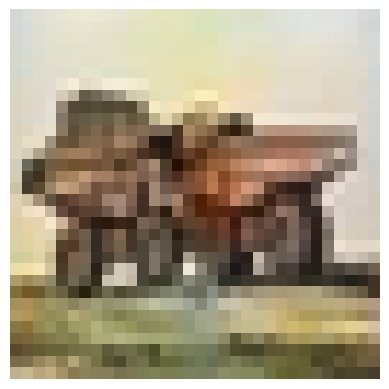

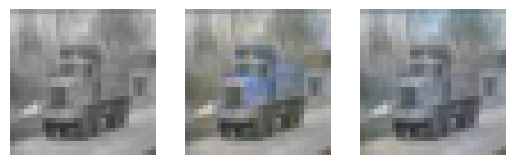

173 / 250173


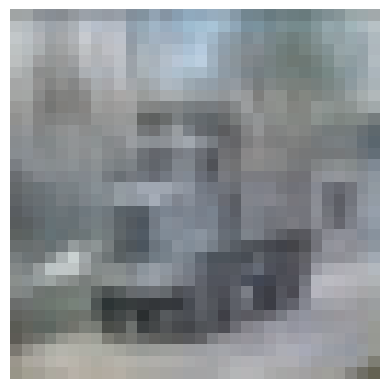

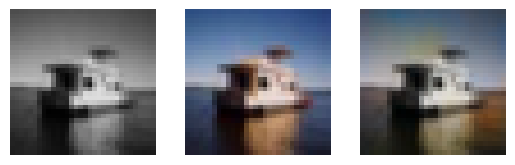

174 / 250174


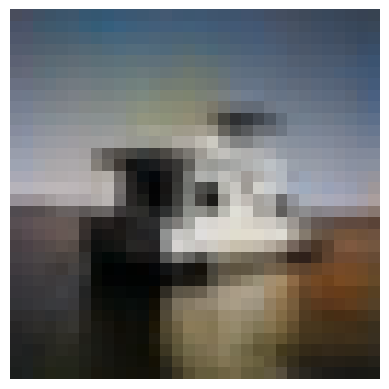

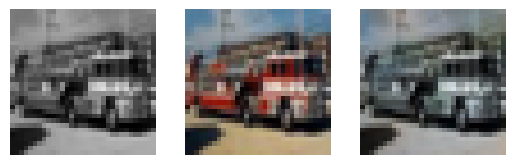

175 / 250175


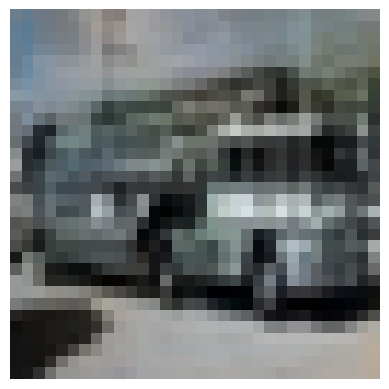

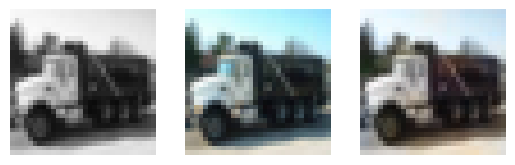

176 / 250176


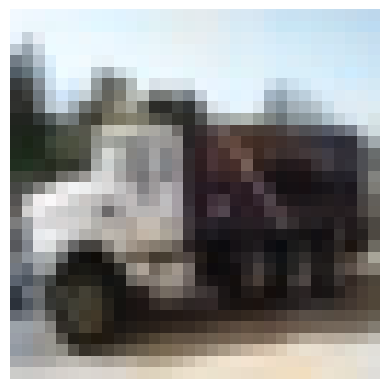

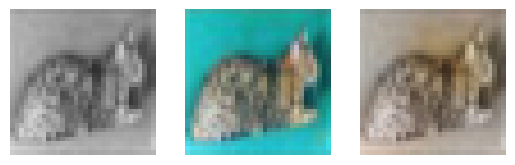

177 / 250177


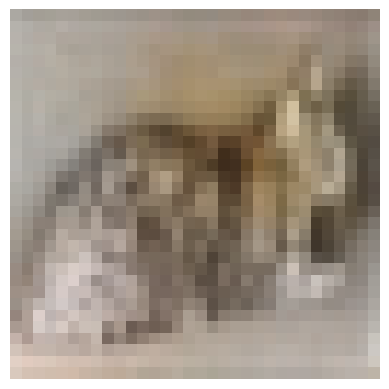

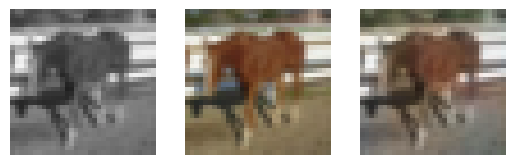

178 / 250178


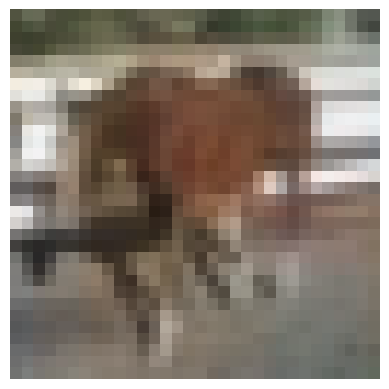

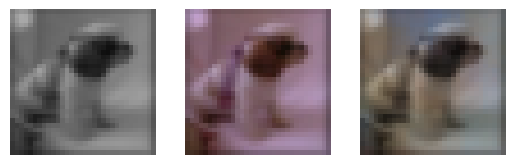

179 / 250179


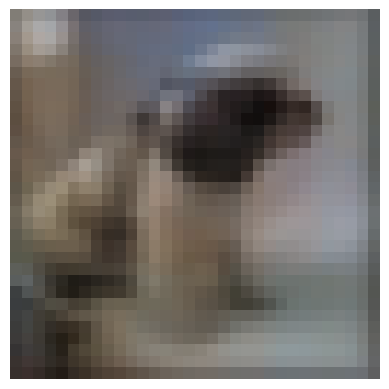

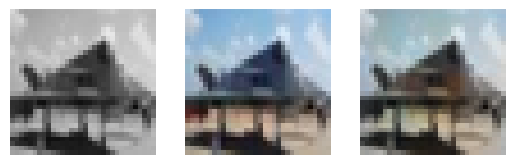

180 / 250180


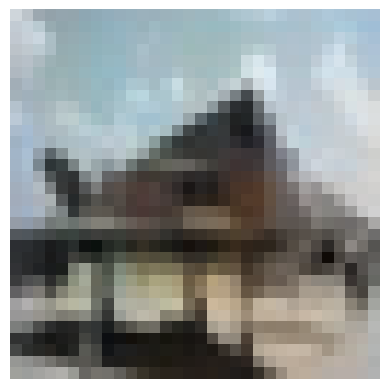

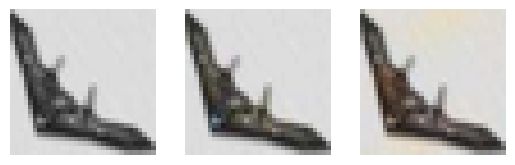

181 / 250181


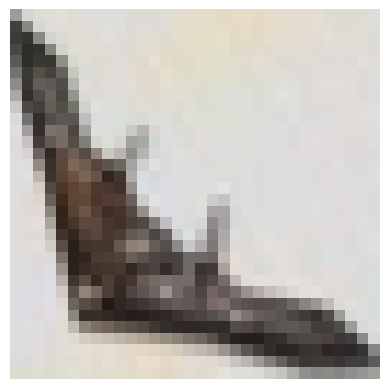

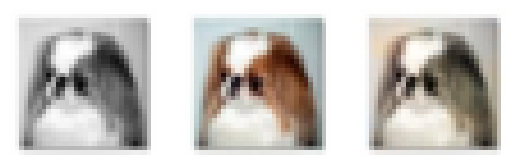

182 / 250182


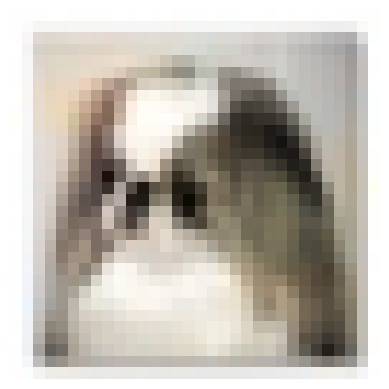

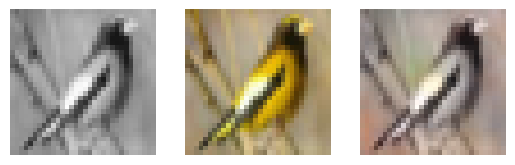

183 / 250183


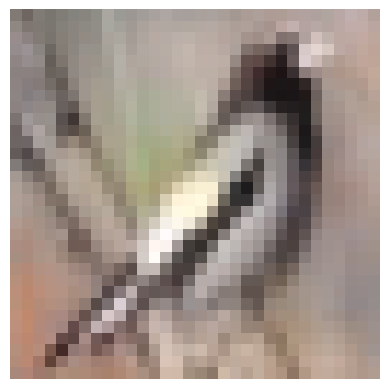

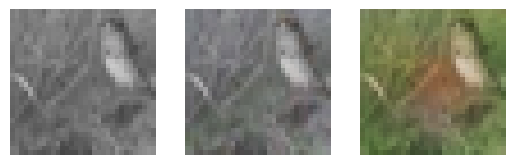

184 / 250184


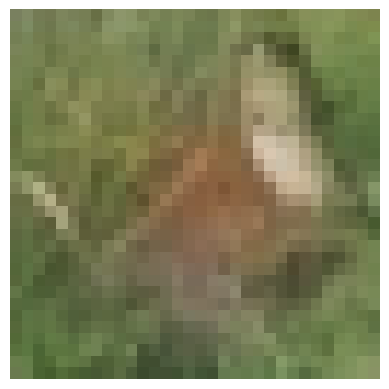

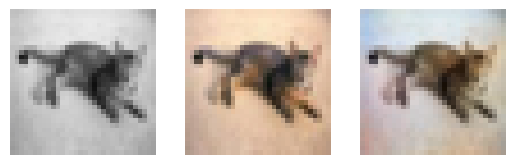

185 / 250185


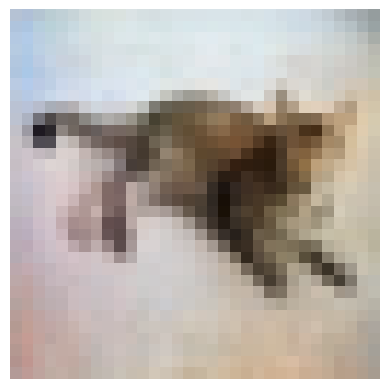

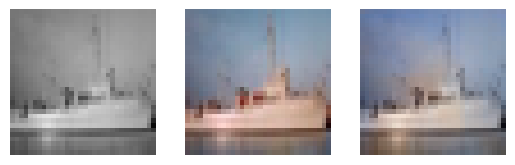

186 / 250186


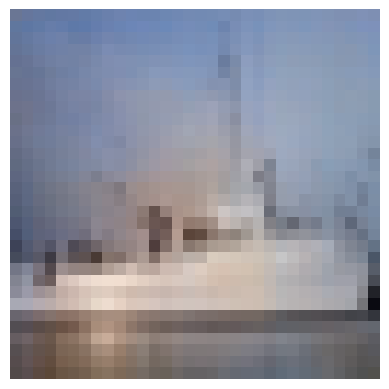

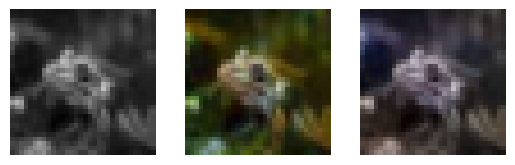

187 / 250187


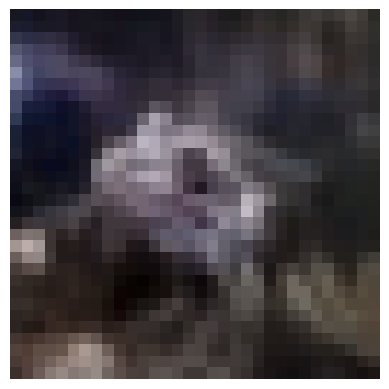

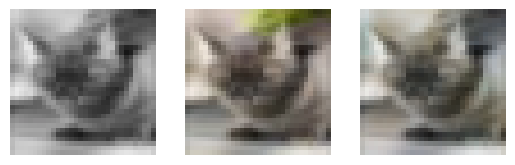

188 / 250188


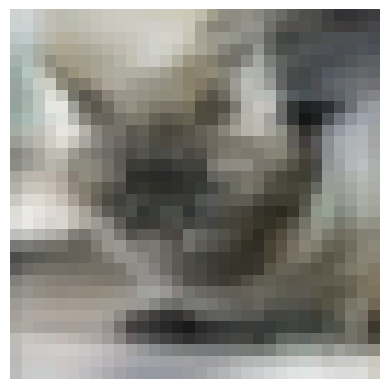

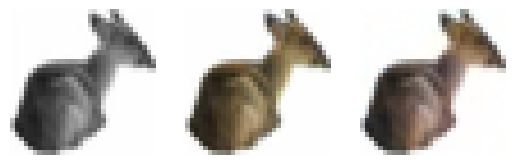

189 / 250189


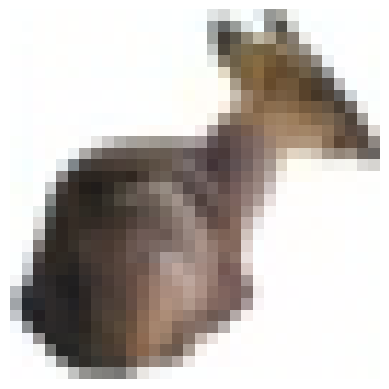

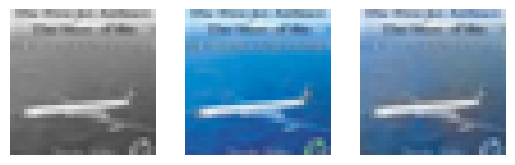

190 / 250190


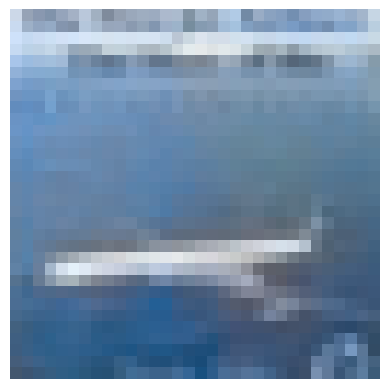

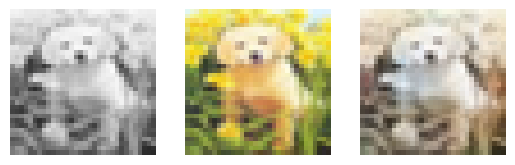

191 / 250191


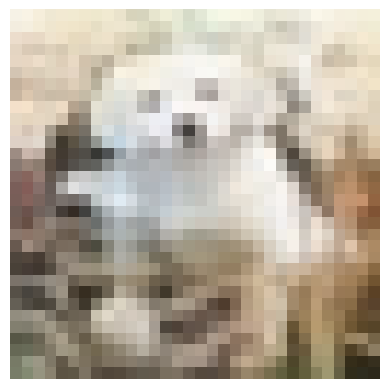

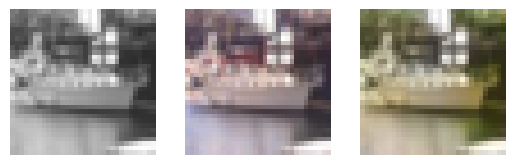

192 / 250192


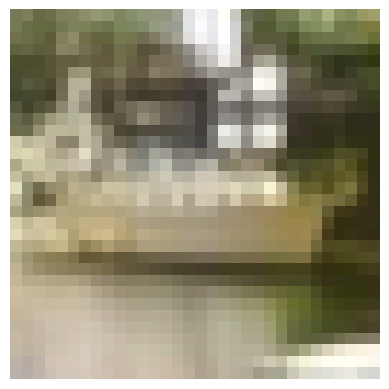

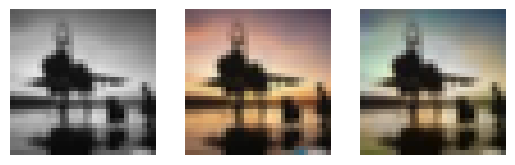

193 / 250193


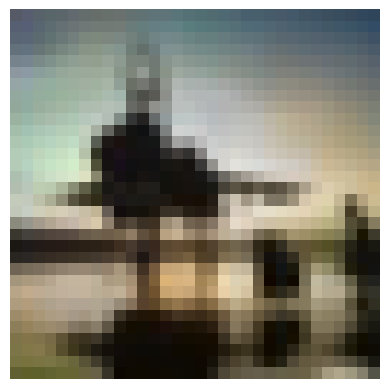

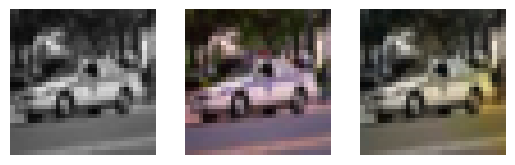

194 / 250194


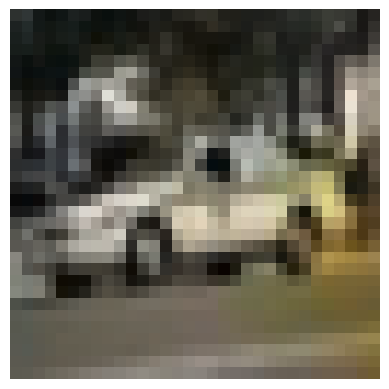

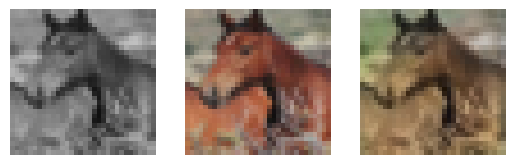

195 / 250195


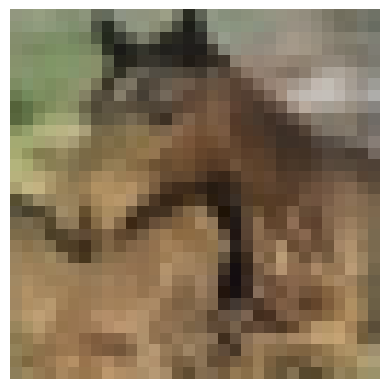

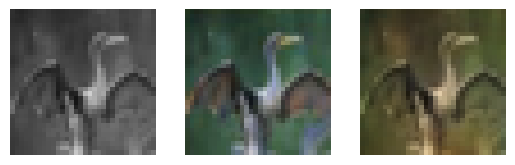

196 / 250196


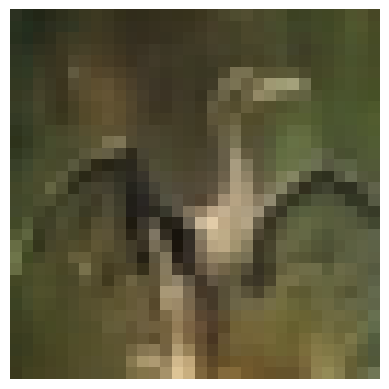

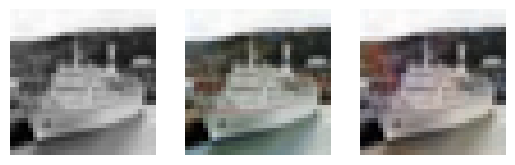

197 / 250197


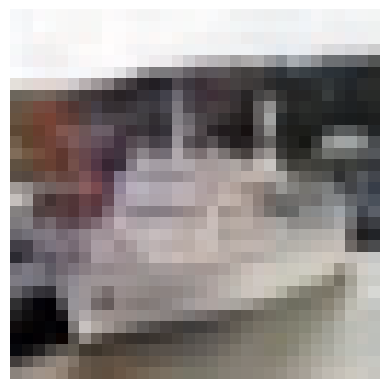

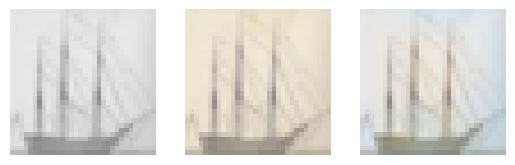

198 / 250198


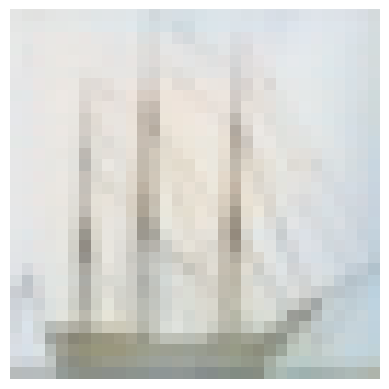

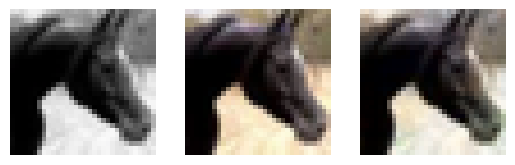

199 / 250199


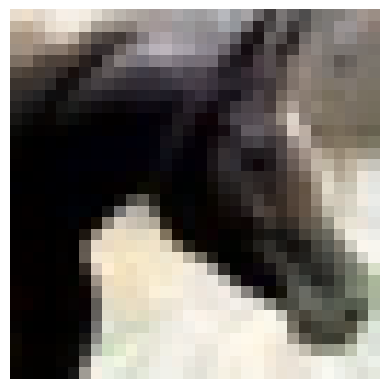

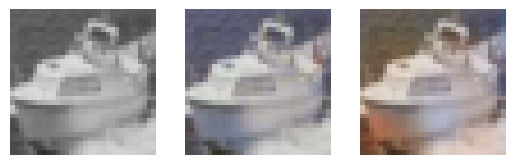

200 / 250200


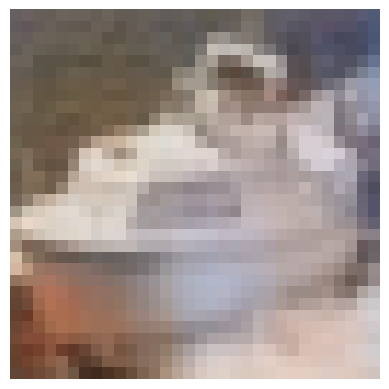

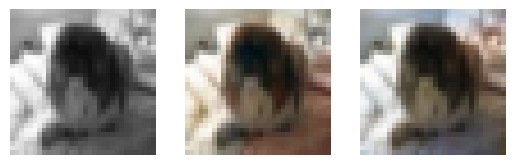

201 / 250201


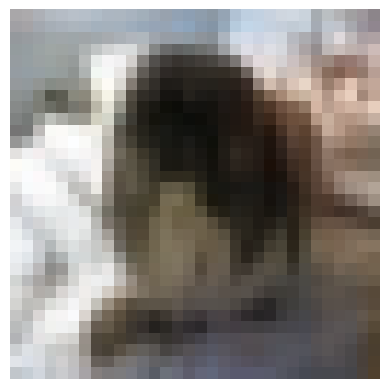

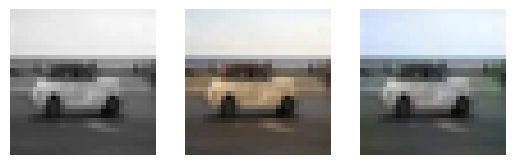

202 / 250202


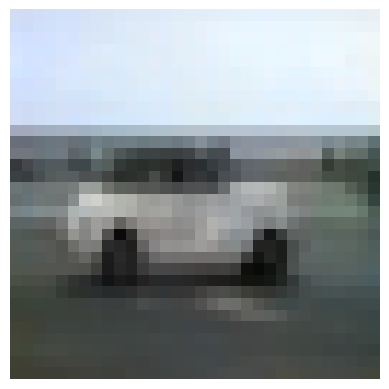

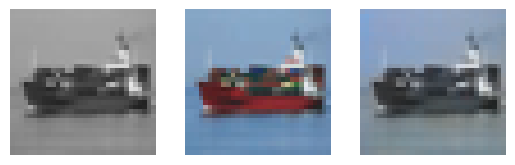

203 / 250203


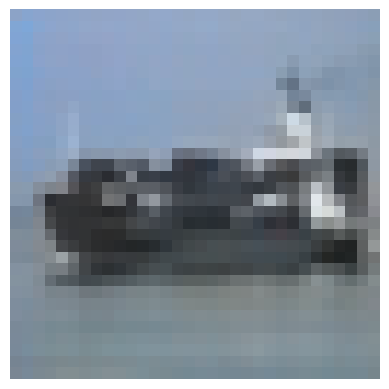

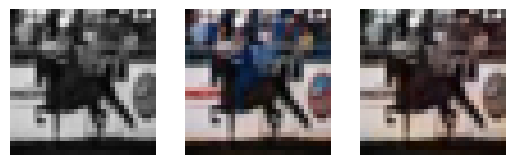

204 / 250204


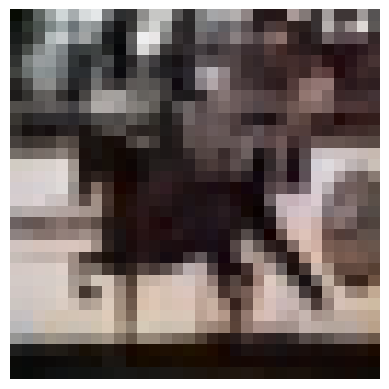

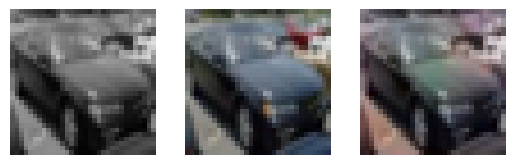

205 / 250205


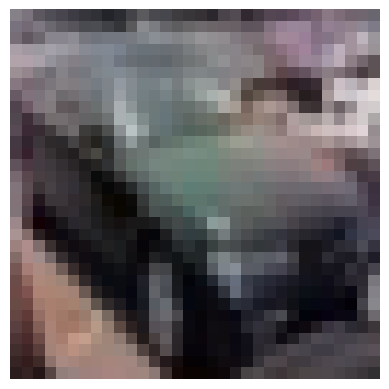

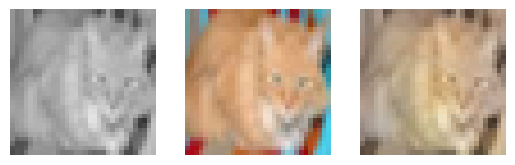

206 / 250206


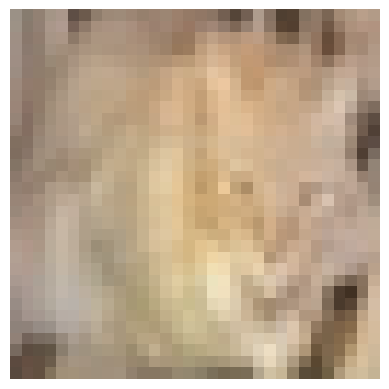

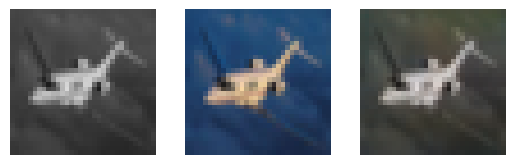

207 / 250207


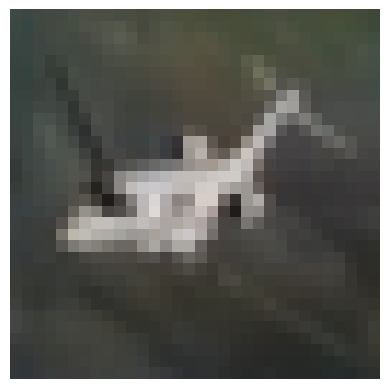

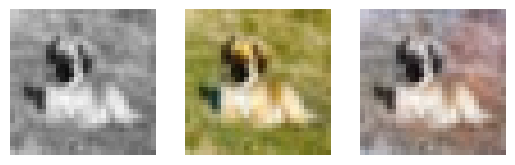

208 / 250208


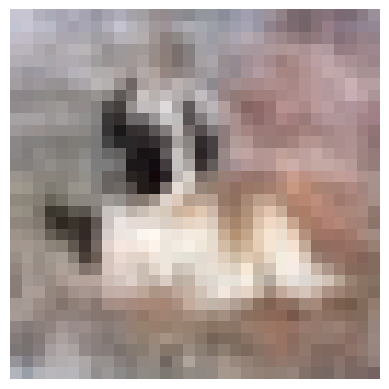

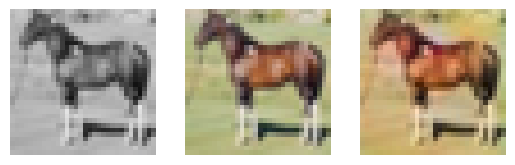

209 / 250209


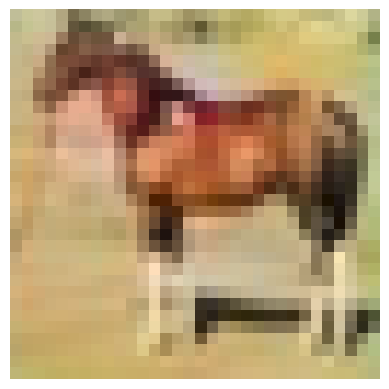

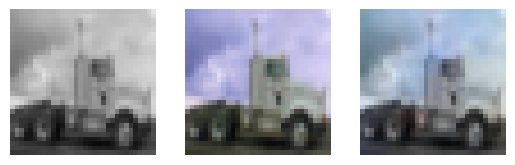

210 / 250210


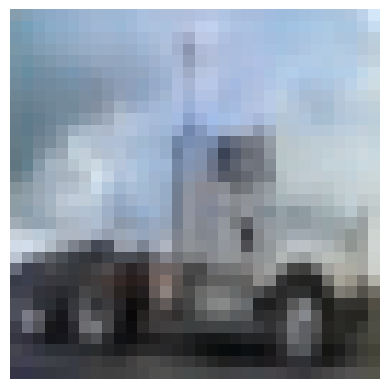

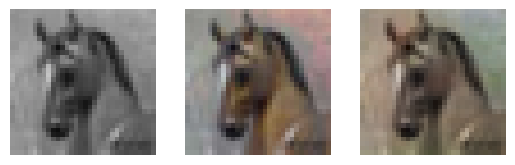

211 / 250211


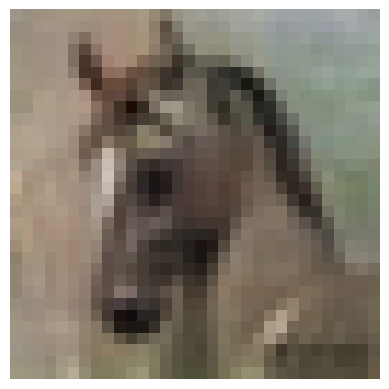

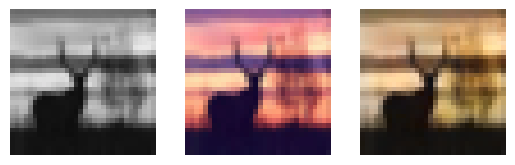

212 / 250212


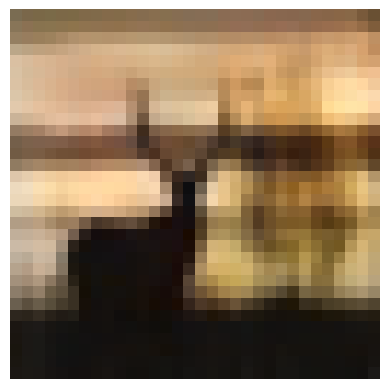

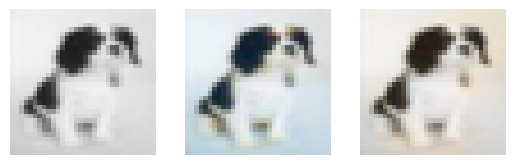

213 / 250213


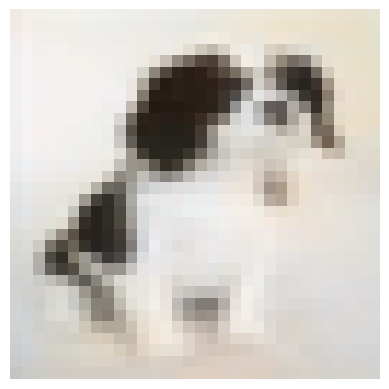

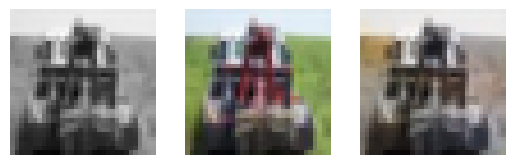

214 / 250214


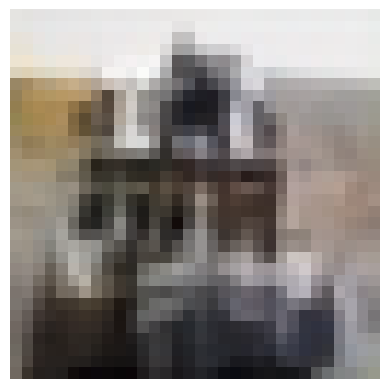

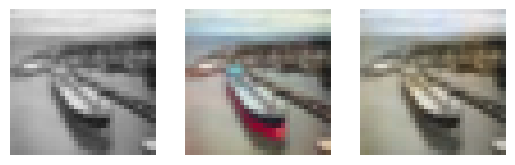

215 / 250215


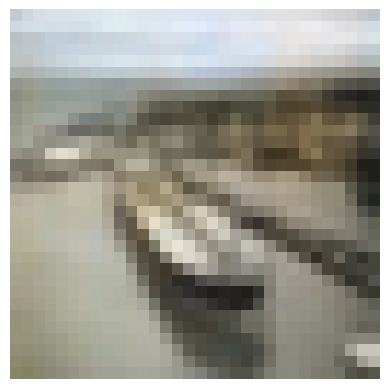

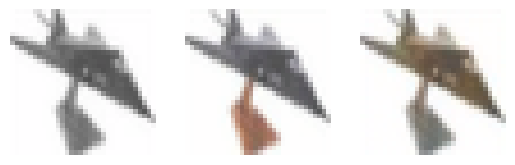

216 / 250216


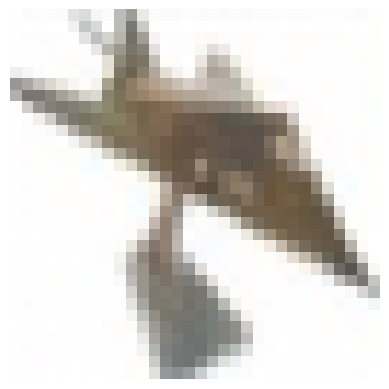

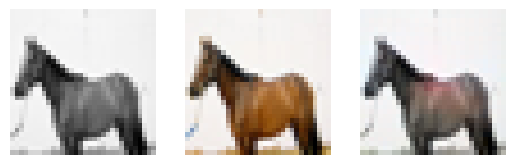

217 / 250217


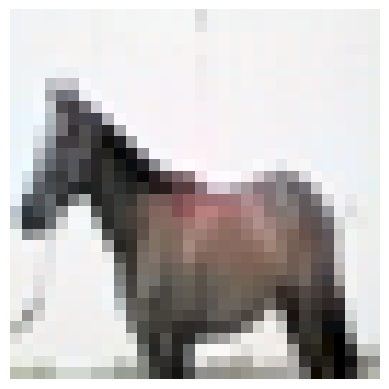

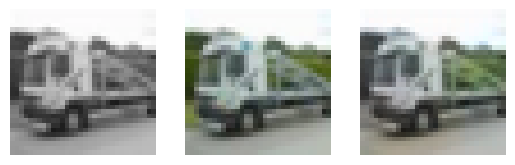

218 / 250218


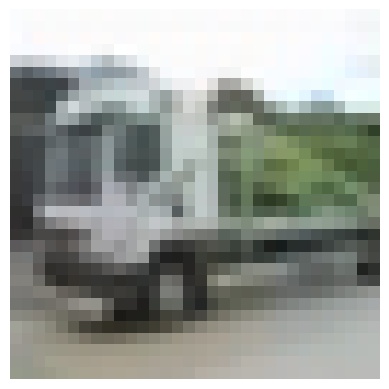

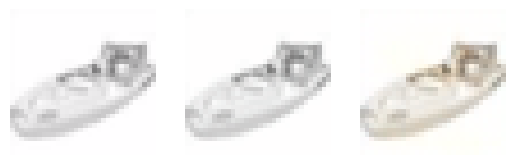

219 / 250219


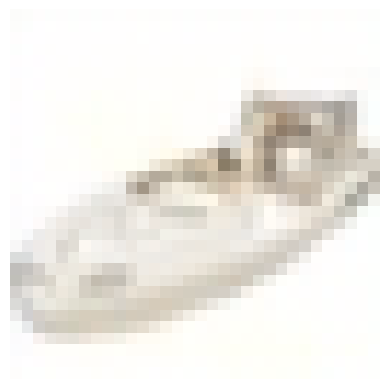

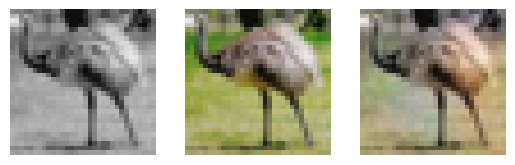

220 / 250220


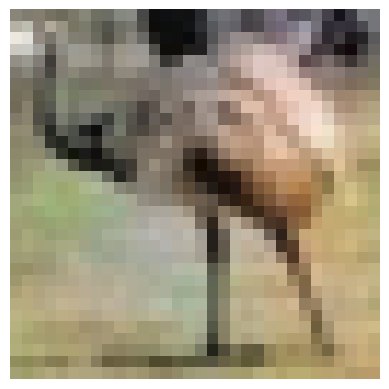

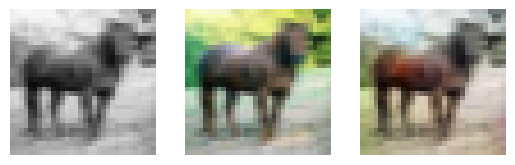

221 / 250221


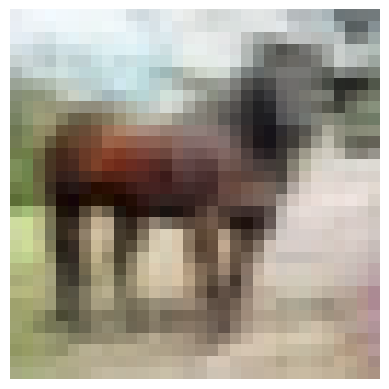

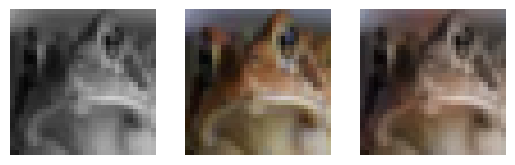

222 / 250222


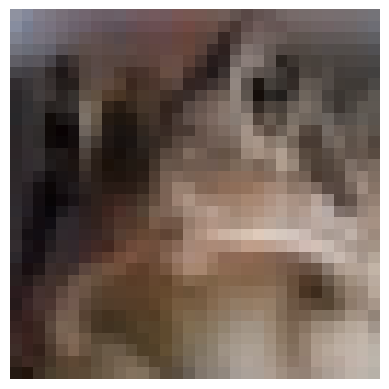

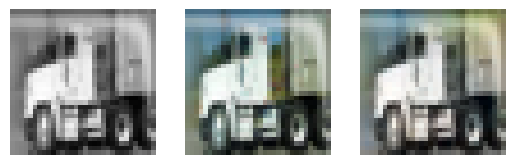

223 / 250223


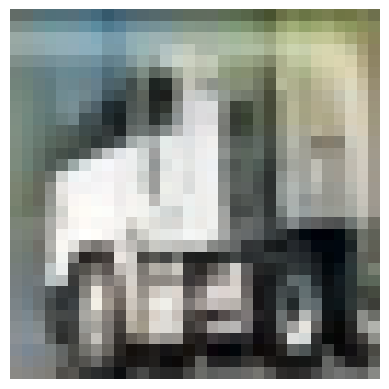

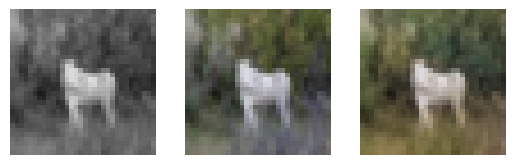

224 / 250224


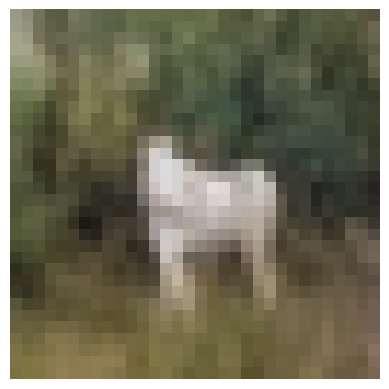

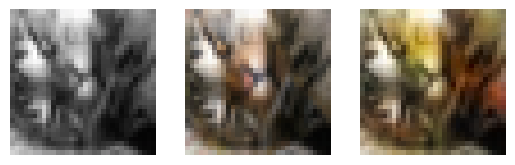

225 / 250225


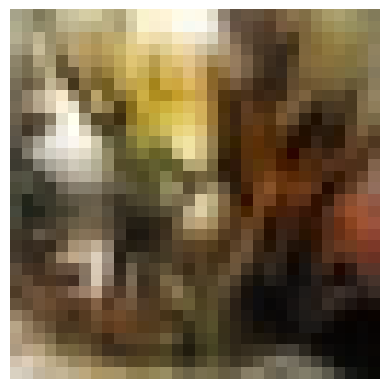

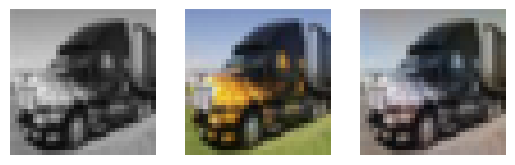

226 / 250226


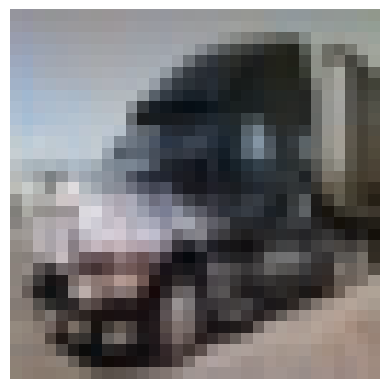

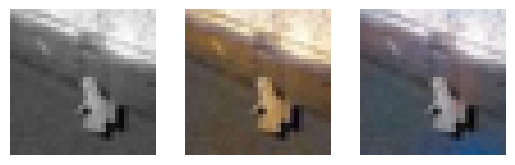

227 / 250227


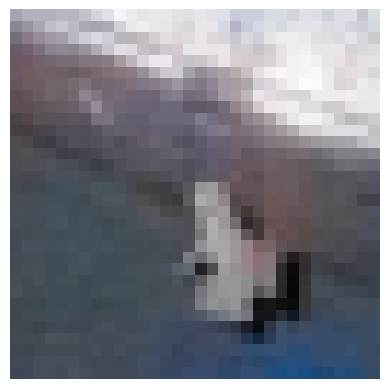

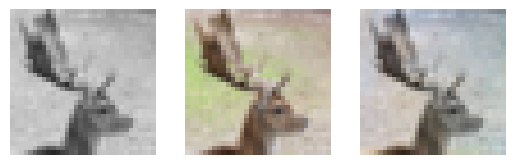

228 / 250228


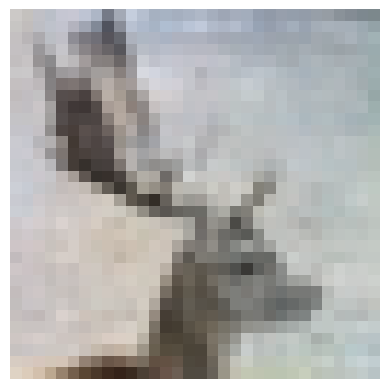

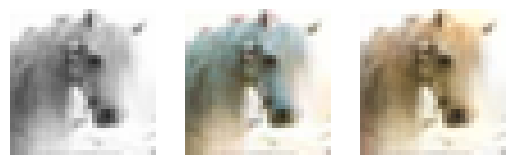

229 / 250229


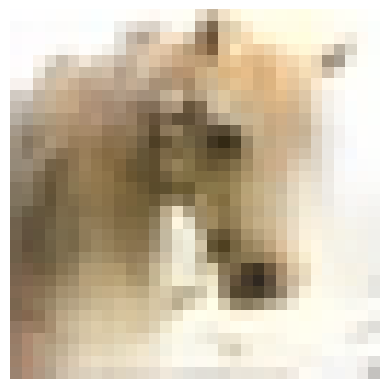

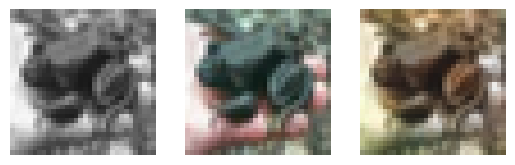

230 / 250230


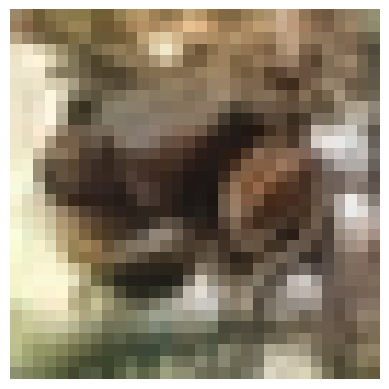

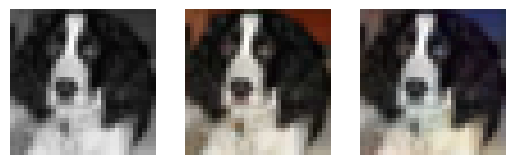

231 / 250231


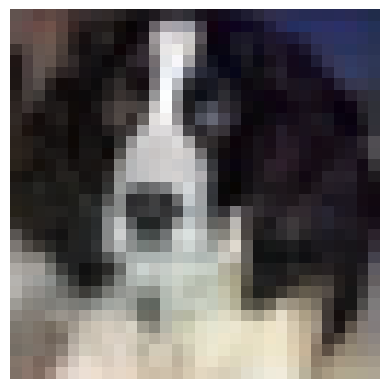

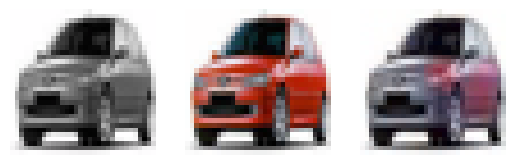

232 / 250232


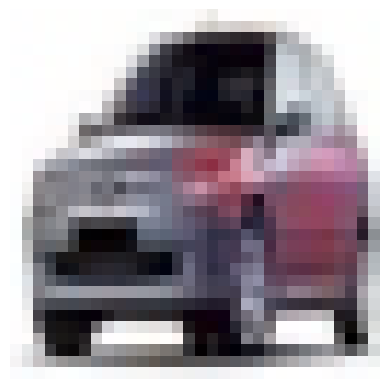

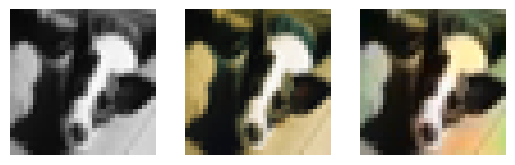

233 / 250233


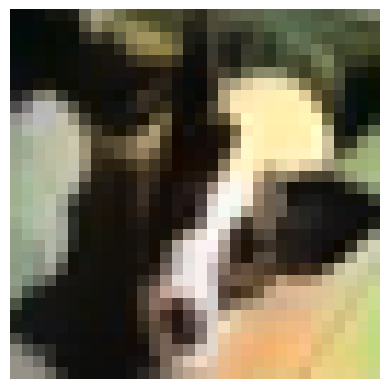

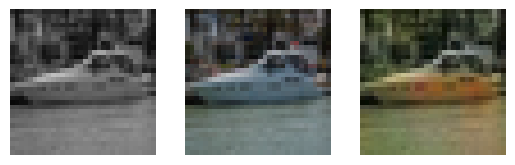

234 / 250234


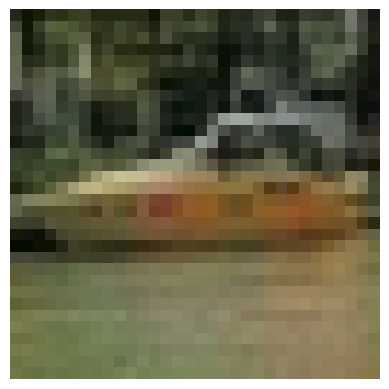

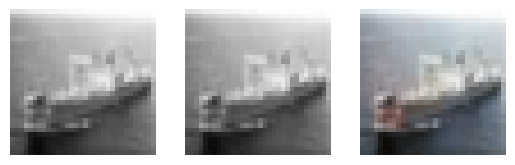

235 / 250235


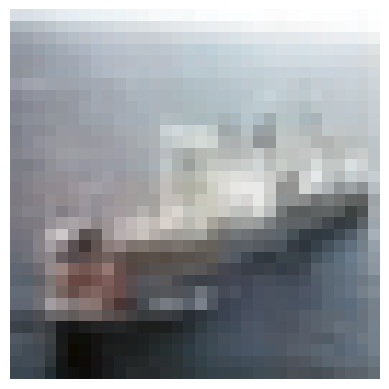

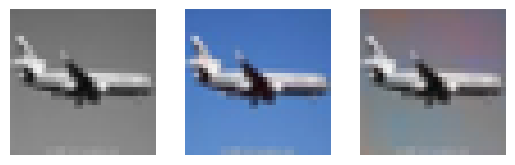

236 / 250236


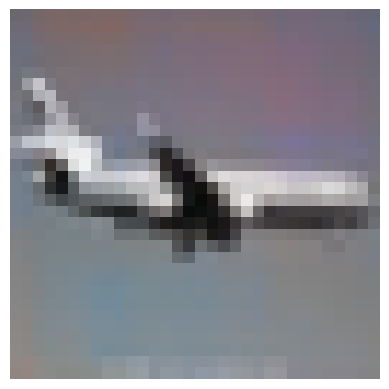

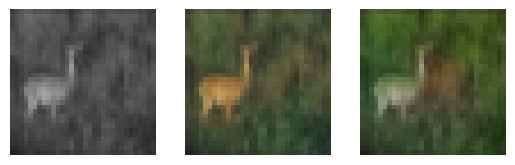

237 / 250237


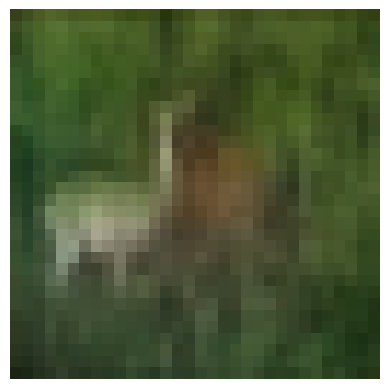

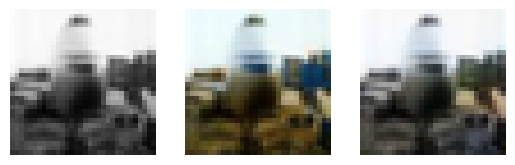

238 / 250238


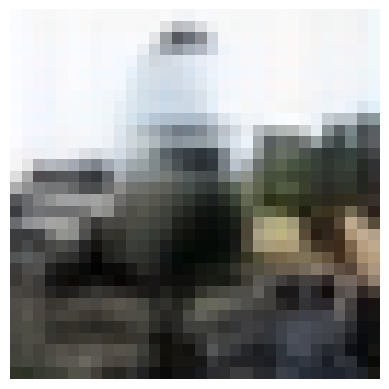

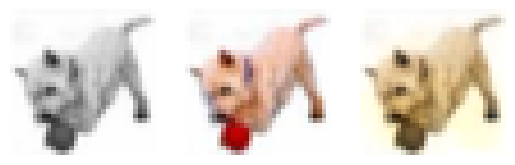

239 / 250239


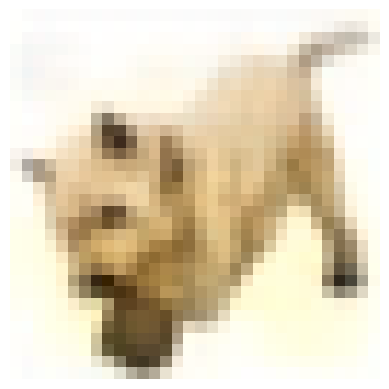

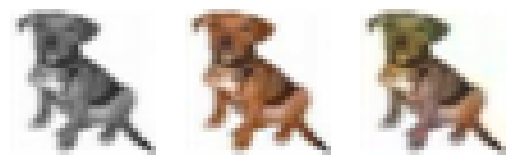

240 / 250240


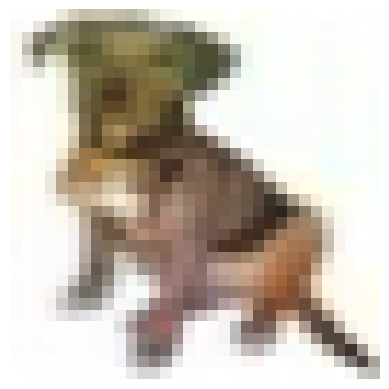

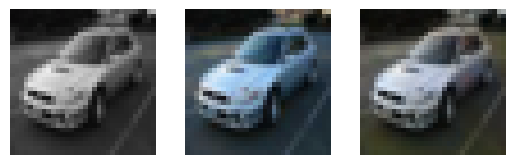

241 / 250241


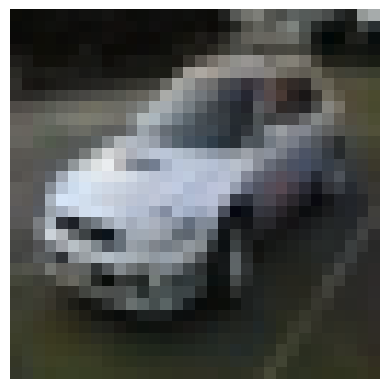

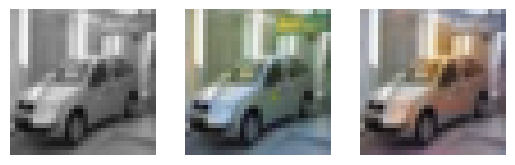

242 / 250242


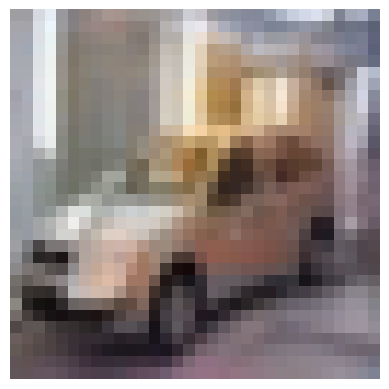

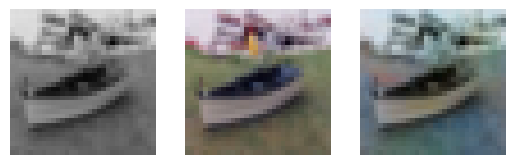

243 / 250243


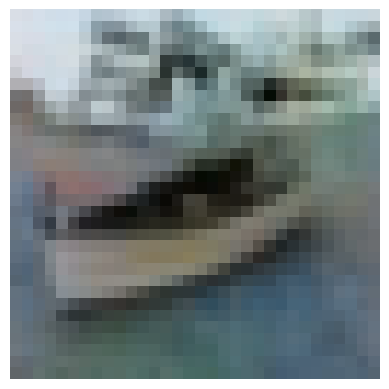

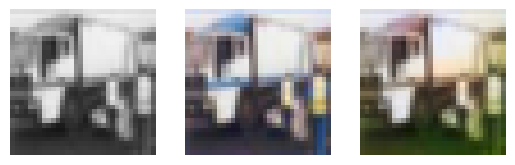

244 / 250244


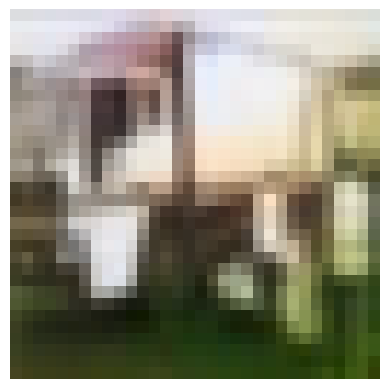

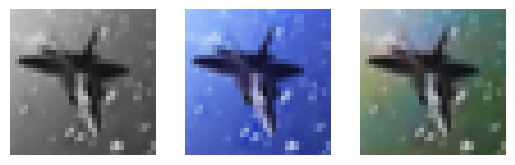

245 / 250245


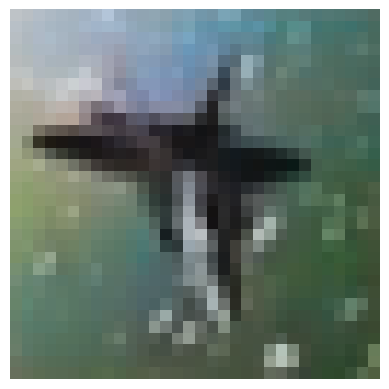

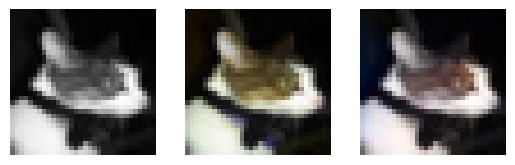

246 / 250246


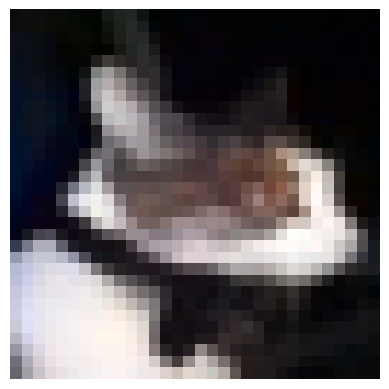

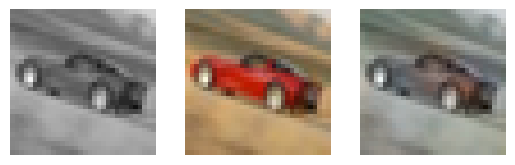

247 / 250247


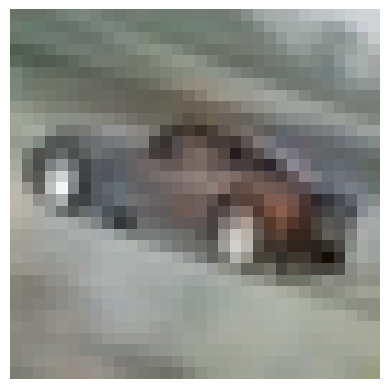

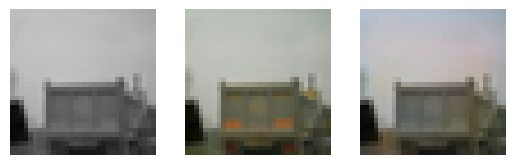

248 / 250248


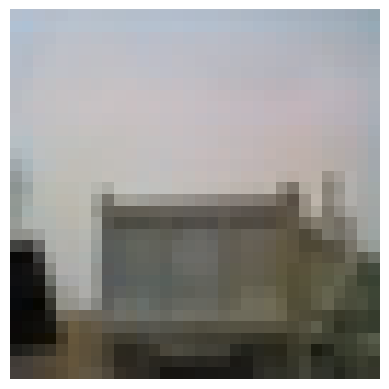

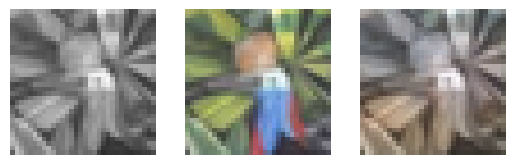

249 / 250249


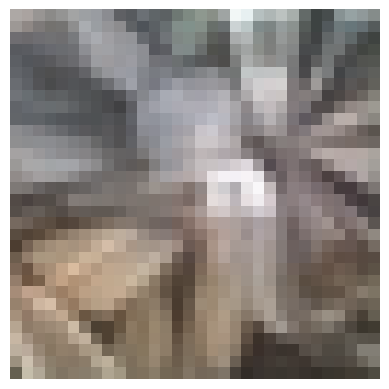

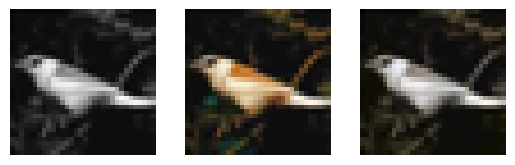

250 / 250

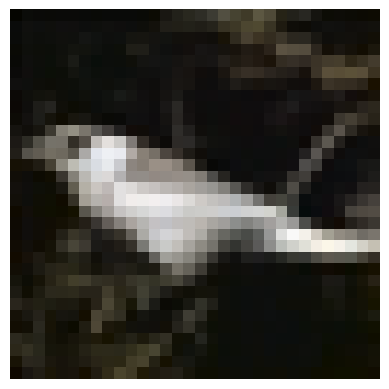

In [17]:
Y_hat = generator(X_test[:250])
total_count = len(Y_hat)

for idx, (x, y, y_hat) in enumerate(zip(X_test[:250], Y_test[:250], Y_hat)):

    # Original RGB image
    orig_lab = np.dstack((x, y * 128))
    orig_rgb = lab2rgb(orig_lab)

    # Grayscale version of the original image
    grayscale_lab = np.dstack((x, np.zeros((IMAGE_SIZE, IMAGE_SIZE, 2))))
    grayscale_rgb = lab2rgb(grayscale_lab)

    # Colorized image
    predicted_lab = np.dstack((x, y_hat * 128))
    predicted_rgb = lab2rgb(predicted_lab)

    print(idx)

    fig = plt.figure()
    fig.add_subplot(1, 3, 1)
    plt.axis('off')
    plt.imshow(grayscale_rgb)
    fig.add_subplot(1, 3, 2)
    plt.axis('off')
    plt.imshow(orig_rgb)
    fig.add_subplot(1, 3, 3)
    plt.axis('off')
    plt.imshow(predicted_rgb)
    plt.show()

    plt.axis('off')
    plt.imshow(grayscale_rgb)
    plt.savefig(os.path.join(WORKDIR, 'results', '{}-bw.png'.format(idx)), dpi=1)

    plt.axis('off')
    plt.imshow(orig_rgb)
    plt.savefig(os.path.join(WORKDIR, 'results', '{}-gt.png'.format(idx)), dpi=1)

    plt.axis('off')
    plt.imshow(predicted_rgb)
    plt.savefig(os.path.join(WORKDIR, 'results', '{}-gan.png'.format(idx)), dpi=1)

    sys.stdout.flush()
    sys.stdout.write('\r{} / {}'.format(idx + 1, total_count))

None

In [15]:
tf.saved_model.save(generator, os.path.join(WORKDIR, "generator-saved-model"))

In [16]:
tf.saved_model.save(discriminator, os.path.join(WORKDIR, "disciminator-saved-model"))